In [2]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math
from utils import *
import random
import pickle
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LinearAxis, Range1d, HoverTool

### Precedent work and model

#### Data and parameter

In [2]:
with open("df_swstch.pkl", "rb") as f:
    df_swstch = pd.read_pickle(f)
df_swstch['Stormwater'] = df_swstch['Stormwater']/1000
df_swstch['Simulation'] = df_swstch['Simulation']/1000
df_swstch['discharge_de_shift'] = df_swstch['discharge_de_shift'].fillna(0)
#df_swstch.head()

In [3]:
# fixed parameter

# [mare foret paturage prairie gazon-fleuri pelouse grille-gazon gravier mineral-compacte]
omegas_st = np.array([0, 0, 0, 2236.43, 1701.78, 0, 0, 0, 0])
# [platform, surface-impermeable]
omega0_st = np.array([5141.19, 6962.80])
# [tank-like roof, roof]
omegat_st = np.array([6225.88, 6035.83]) 

area_tt = sum(omega0_st) + sum(omegas_st) + sum(omegat_st)
imper = area_tt - sum(omegas_st)
imper

24365.7

#### Soil caracteristics

In [5]:
soil = dict()
texture=["sand", "loamy sand", "sandy loam", "loam", "clay"]
for t in texture:
    soil[t] = dict()

In [6]:
soil['sand'] = {"Ks":500, "n":0.35, "beta":12.1, "sh":0.08, "sw":0.11, "ss":0.33, "sfc":0.35}
soil['loamy sand'] = {"Ks":100, "n":0.42, "beta":12.7, "sh":0.08, "sw":0.11, "ss":0.31, "sfc":0.52}
soil['sandy loam'] = {"Ks":80, "n":0.43, "beta":13.8, "sh":0.14, "sw":0.18, "ss":0.46, "sfc":0.56}
soil['loam'] = {"Ks":20, "n":0.45, "beta":14.8, "sh":0.19, "sw":0.24, "ss":0.57, "sfc":0.65}
soil['clay'] = {"Ks":1, "n":0.5, "beta":26.8, "sh":0.47, "sw":0.52, "ss":0.78, "sfc":0.99}

In [8]:
n = 0.45          # porosity 
Z_root = 70
Z_soil = n * Z_root*2.5   # grass root depth[cm]
E_max = 0.5             #maximum evapotranspiration for grass[cm/day]
E_w = E_max / 8        # evapotraspiration at soil wilting point [cm/day]
beta = 14.8            # soil characteristics
s_h = 0.19 
s_w = 0.24
s_s = 0.57
s_fc = 0.99
Ks = 20              # saturated hydraulic conductivity [cm/day]

eta_w = E_w / Z_soil;        # normalized maximum evapotranspiration [-/day]
eta = E_max / Z_soil
m = Ks / (Z_soil * (np.exp(beta * (1 - s_fc)) - 1))

#### other caracteristics

In [9]:
k = 100 #[/day] Time constant
rf2s = 0.5 # meaning half of the rain falling on the roof will go to the soil. 
           # the proportion of rainfall on the roof that will go to the soil. Initial value is 0.5 but I try other values

#### model

In [10]:
def model_st(df, k=100, frac_rt2s=0.5, frac_rt2tk=0, Z_root=70, E_max=0.5, E_w=0.0625, heavy=55/600000, soiltype="loamy sand",\
        omegas=sum(omegas_st), omega0=sum(omega0_st), omegat=sum(omegat_st), Vtmax=0, lag=0, resolution=5):
    
    rain = df['precp'].fillna(0)
    rain_lag = rain if lag==0 else np.concatenate((np.zeros(lag), rain[:-lag]))

    # Soil parameters
    Ks = soil[soiltype]['Ks']
    n = soil[soiltype]['n']
    beta = soil[soiltype]['beta']
    s_h = soil[soiltype]['sh']
    s_w = soil[soiltype]['sw']
    s_s = soil[soiltype]['ss']
    s_fc = soil[soiltype]['sfc']
    # Initialization
    y0 = [0, s_s, 0]
    y_result = np.zeros((df.shape[0], 3))
    y_result[0] = y0
    dydt = np.zeros(3)
    Qs = np.zeros(df.shape[0])
    Qout = np.zeros(df.shape[0])
    Qt = np.zeros(df.shape[0])
    V_runoff = np.zeros(df.shape[0])
    

    for i in range(df.shape[0]-1):
        p = rain_lag[i]/(1000*5*60) #convert from mm/5min to m/s

        ####### Qs #########
        if y_result[i,1] >= s_fc:
            Qs[i] = p * (omegas + frac_rt2s*omegat)
        elif p>heavy:
            Qs[i] = (p-heavy)*(omegas + frac_rt2s*omegat)
        else:
            Qs[i] = 0

        #============ Qout ===============#
        V_runoff[i] = y_result[i,0]*omega0 # Water volume of V0 reservoir at time point i
        Qout[i] = k * V_runoff[i] / 86400 # Turn k [/day] to k [/s]

        #============ Qt =================#
        Vt = frac_rt2tk*omegat*y_result[i, 2]
        Qt[i] = p*frac_rt2tk*omegat if (Vt>Vtmax) else 0

        #==============Road reservoir==========#
        dydt[0] = (p*(omega0+(1-frac_rt2tk)*(1-frac_rt2s)*omegat) + Qs[i] + Qt[i] - Qout[i])/omega0
        
        y_result[i+1, 0] = y_result[i, 0] + dydt[0]*60*resolution # tspan resolution is 10 min = 600s
        if y_result[i+1, 0] < 0:
            y_result[i+1, 0] = 0
            
        #==============Soil reservoir==========#
        Z_soil = n*Z_root
        dydt[1] = p*(1+(1-frac_rt2tk)*frac_rt2s*omegat/omegas)/ (Z_soil / 100) \
                 - rho(y_result[i, 1],n, Z_root, E_max, E_w, beta, s_h, s_w, s_s, s_fc, Ks) / 86400

        y_result[i+1, 1] = y_result[i, 1] + dydt[1]*60*resolution
        if y_result[i+1, 1] >=1:
            y_result[i+1, 1] = 1

        #==============Tank reservoir==========#
        if frac_rt2tk != 0:
            dydt[2] = p - (Qt+Qp)/(frac_rt2tk*omegat)
            y_result[i+1, 2] = y_result[i, 2] + dydt[2]*60*resolution
            hmax = Vtmax/(frac_rt2tk*omegat)
            if y_result[i+1, 2] >= hmax:
                y_result[i+1, 2] = hmax
        else:
            dydt[2] = 0
            y_result[:, 2] = 0
    
        
    df_return = df.copy()
    # column = "Qout_k"+str(k)
    # df_return[column] = Qout
    df_return['Qout'] = Qout*10
    df_return['Qs'] = Qs
    df_return['Qt'] = Qt
    df_return['soil_mois'] = y_result[:,1]
    df_return['h_tank'] = y_result[:,2]
    df_return['runoff'] = V_runoff

    return df_return

### Data integration - From csv to pkl

#### Pluviometer

Until 26/11

In [2]:
# CSV file path
csv_file = "pluviometer_until_261124.csv"

# Charger le CSV en spécifiant le bon séparateur et l'encodage
df = pd.read_csv(csv_file, sep=";", encoding="ISO-8859-1", decimal=".")

# Sauvegarder en format pickle
pkl_file = "pluviometer.pkl"
df.to_pickle(pkl_file)

# Confirmer que le fichier a bien été sauvegardé
print(f"Fichier sauvegardé en tant que {pkl_file}")



Fichier sauvegardé en tant que pluviometer.pkl


In [2]:
with open('pluviometer.pkl','rb') as f:
    df_pluviometer = pd.read_pickle(f)

# Change title precipitation column
df_pluviometer = df_pluviometer.rename(columns={"Cumul de pluviomètrie [0] (mm)": "precp"}) #precp in mm
df_pluviometer = df_pluviometer.rename(columns={"Compteur[0] (22[0])": "compteur"})

df_pluviometer.head()

,Date,Sn,Name,compteur,precp
0,01.11.2024 00:04,IJA0102-00009933,Pluvio_Gr,0,0.0
1,01.11.2024 00:09,IJA0102-00009933,Pluvio_Gr,0,0.0
2,01.11.2024 00:14,IJA0102-00009933,Pluvio_Gr,0,0.0
3,01.11.2024 00:19,IJA0102-00009933,Pluvio_Gr,0,0.0
4,01.11.2024 00:24,IJA0102-00009933,Pluvio_Gr,0,0.0


Until 16/12

In [14]:
# CSV file path
csv_file = "rain_data_261124_161224.csv"

# Charger le CSV en spécifiant le bon séparateur et l'encodage
df = pd.read_csv(csv_file, sep=";", encoding="ISO-8859-1", decimal=",")

# Sauvegarder en format pickle
pkl_file = "pluvio_2.pkl"
df.to_pickle(pkl_file)

# Confirmer que le fichier a bien été sauvegardé
print(f"Fichier sauvegardé en tant que {pkl_file}")


Fichier sauvegardé en tant que pluvio_2.pkl


In [3]:
with open('pluvio_2.pkl','rb') as f:
    df_pluvio_2 = pd.read_pickle(f)

# Change title precipitation column
df_pluvio_2 = df_pluvio_2.rename(columns={"Cumul de pluviomÃ©trie[0] (mm)": "precp"}) #precp in mm
df_pluvio_2 = df_pluvio_2.rename(columns={"Compteur[0] (22[0])": "compteur"})
df_pluvio_2['precp'] = pd.to_numeric(df_pluvio_2['precp'], errors='coerce')

df_pluvio_2

,Date,Sn,Name,compteur,precp,precp2
0,2024-11-26 12:35:00,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0
1,2024-11-26 12:40:00,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0
2,2024-11-26 12:45:00,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0
3,2024-11-26 12:50:00,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0
4,2024-11-26 12:55:00,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0
...,...,...,...,...,...,...
5737,2024-12-16 10:40:00,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0
5738,2024-12-16 10:45:00,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0
5739,2024-12-16 10:50:00,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0
5740,2024-12-16 10:55:00,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0


#### River level

In [16]:
# CSV file path
csv_file = "riverlevel.csv"

# Charger le CSV en spécifiant le bon séparateur et l'encodage
df = pd.read_csv(csv_file, sep=";", encoding="ISO-8859-1", decimal=".")

# Sauvegarder en format pickle
pkl_file = "riverlevel.pkl"
df.to_pickle(pkl_file)

# Confirmer que le fichier a bien été sauvegardé
print(f"Fichier sauvegardé en tant que {pkl_file}")


Fichier sauvegardé en tant que riverlevel.pkl


In [17]:
with open('riverlevel.pkl','rb') as f:
    df_riverlevel = pd.read_pickle(f)

# Change title precipitation column
df_riverlevel = df_riverlevel.rename(columns={"Hauteur d'eau[0] (mm)": "water level (mm)"})
df_riverlevel = df_riverlevel.rename(columns={"Température de mesure[0] (°C)": "temperature"})

#df_riverlevel

#### Triades outlet

In [18]:

# CSV file path
csv_file = "triades_outlet.csv"

# Charger le CSV en spécifiant le bon séparateur et l'encodage
df = pd.read_csv(csv_file, sep=";", encoding="ISO-8859-1", decimal=",")

# Sauvegarder en format pickle
pkl_file = "triades_outlet.pkl"
df.to_pickle(pkl_file)

# Confirmer que le fichier a bien été sauvegardé
print(f"Fichier sauvegardé en tant que {pkl_file}")


Fichier sauvegardé en tant que triades_outlet.pkl


In [19]:
with open('triades_outlet.pkl','rb') as f:
    df_triades = pd.read_pickle(f)

# Change title precipitation column
df_triades = df_triades.rename(columns={"Hauteur d'eau[0] (mm)": "water level (mm)"})
df_triades = df_triades.rename(columns={"Température de mesure[0] (°C)": "temperature"})

df_triades

,Date,Sn,Name,temperature,water level (mm)
0,01.11.2024 00:00,IJA0102-00006283,Rejet Triaud,12,19
1,01.11.2024 00:05,IJA0102-00006283,Rejet Triaud,12,22
2,01.11.2024 00:10,IJA0102-00006283,Rejet Triaud,12,20
3,01.11.2024 00:15,IJA0102-00006283,Rejet Triaud,12,21
4,01.11.2024 00:20,IJA0102-00006283,Rejet Triaud,12,19
...,...,...,...,...,...
7320,26.11.2024 10:00,IJA0102-00006283,Rejet Triaud,9,39
7321,26.11.2024 10:05,IJA0102-00006283,Rejet Triaud,9,39
7322,26.11.2024 10:10,IJA0102-00006283,Rejet Triaud,10,40
7323,26.11.2024 10:15,IJA0102-00006283,Rejet Triaud,10,37


until 16/12

In [20]:
# CSV file path
csv_file = "Triaudes_data_261124_161224.csv"

# Charger le CSV en spécifiant le bon séparateur et l'encodage
df = pd.read_csv(csv_file, sep=";", encoding="ISO-8859-1", decimal=".")

# Sauvegarder en format pickle
pkl_file = "triades_2.pkl"
df.to_pickle(pkl_file)

# Confirmer que le fichier a bien été sauvegardé
print(f"Fichier sauvegardé en tant que {pkl_file}")

Fichier sauvegardé en tant que triades_2.pkl


In [21]:
with open('triades_2.pkl','rb') as f:
    df_triades2 = pd.read_pickle(f)

# Change title precipitation column
df_triades2 = df_triades2.rename(columns={"Hauteur d'eau[0] (mm)": "water level (mm)"})
df_triades2

,Date,Sn,Name,water level (mm)
0,26.11.2024 12:35,IJA0102-00006283,Rejet Triaud,44
1,26.11.2024 12:40,IJA0102-00006283,Rejet Triaud,47
2,26.11.2024 12:45,IJA0102-00006283,Rejet Triaud,46
3,26.11.2024 12:50,IJA0102-00006283,Rejet Triaud,43
4,26.11.2024 12:55,IJA0102-00006283,Rejet Triaud,46
...,...,...,...,...
5737,16.12.2024 10:40,IJA0102-00006283,Rejet Triaud,19
5738,16.12.2024 10:45,IJA0102-00006283,Rejet Triaud,23
5739,16.12.2024 10:50,IJA0102-00006283,Rejet Triaud,20
5740,16.12.2024 10:55,IJA0102-00006283,Rejet Triaud,20


### Plot

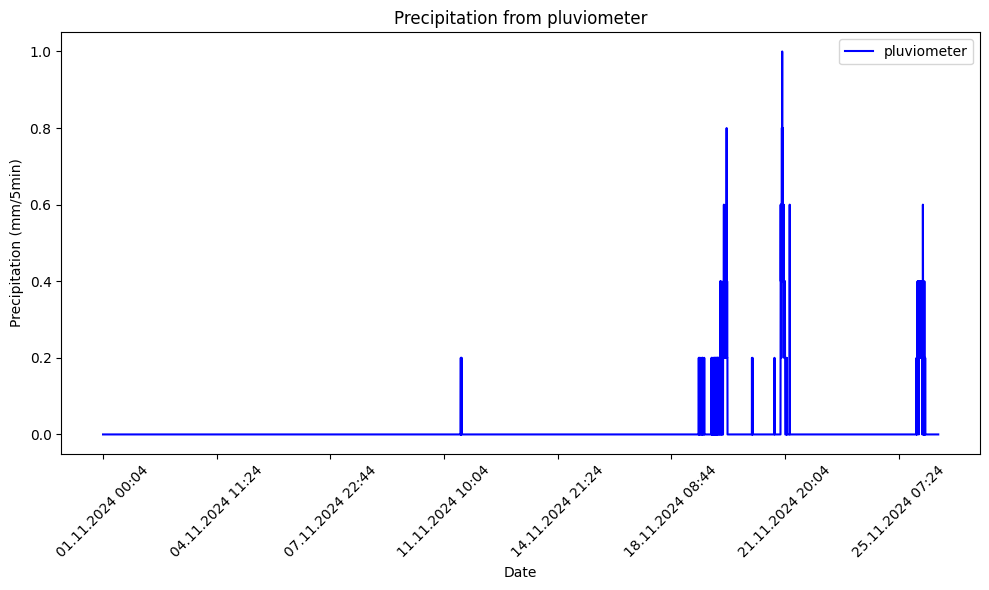

In [22]:
# Plot precipitation data

plt.figure(figsize=(10, 6))
plt.plot(df_pluviometer['Date'], df_pluviometer['precp'], label='pluviometer', color='blue')

# Show one every 1000 dates.
plt.xticks(df_pluviometer['Date'][::1000], rotation=45)

plt.xlabel('Date')
plt.ylabel('Precipitation (mm/5min)')
plt.title('Precipitation from pluviometer')
plt.legend()

plt.tight_layout()
plt.show()


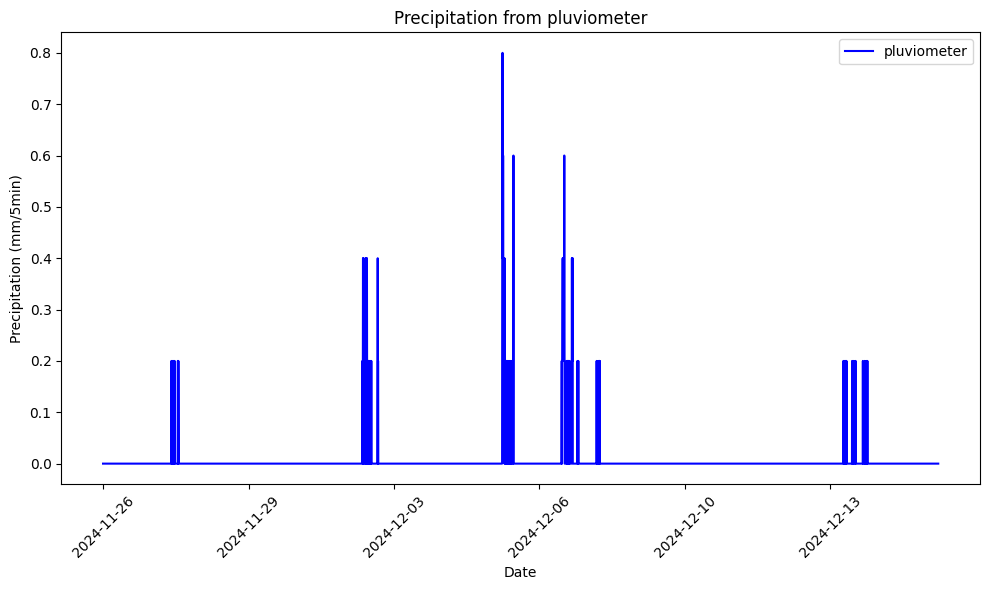

In [23]:
# Plot precipitation data

df_pluvio_2['Date'] = pd.to_datetime(df_pluvio_2['Date'], errors='coerce',dayfirst=True)

plt.figure(figsize=(10, 6))
plt.plot(df_pluvio_2['Date'], df_pluvio_2['precp'], label='pluviometer', color='blue')

# Show one every 1000 dates.
plt.xticks(df_pluvio_2['Date'][::1000], rotation=45)

plt.xlabel('Date')
plt.ylabel('Precipitation (mm/5min)')
plt.title('Precipitation from pluviometer')
plt.legend()

plt.tight_layout()
plt.show()


#### Lausanne data (from previous project)

In [24]:
with open("df_swstch.pkl", "rb") as f:
    df_swstch = pd.read_pickle(f)

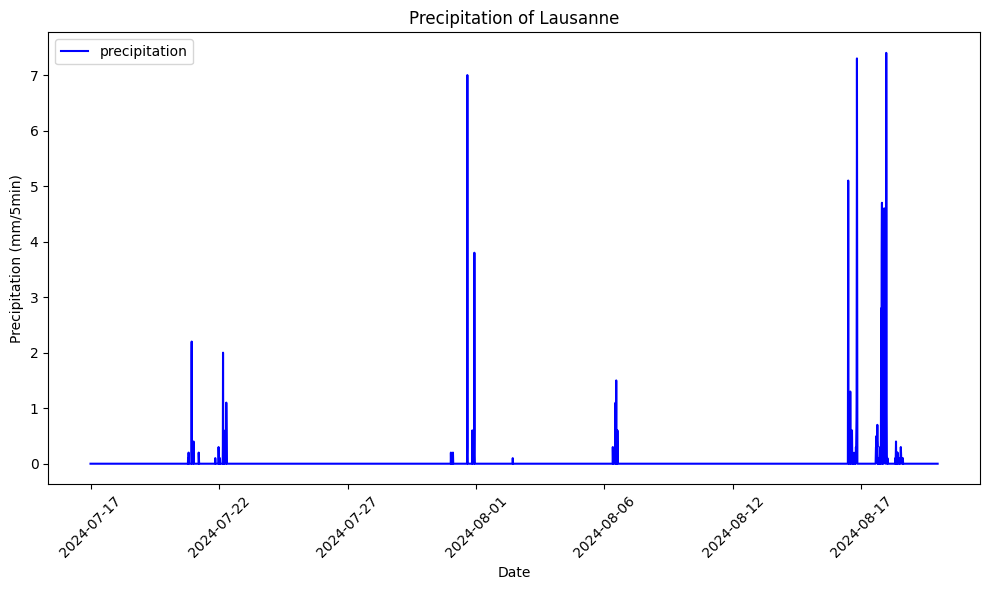

In [25]:
# Plot precipitation data

plt.figure(figsize=(10, 6))
plt.plot(df_swstch['time'], df_swstch['precp'], label='precipitation', color='blue')

# Show one every 1000 dates.
plt.xticks(df_swstch['time'][::1500], rotation=45)

plt.xlabel('Date')
plt.ylabel('Precipitation (mm/5min)')
plt.title('Precipitation of Lausanne')
plt.legend()

plt.tight_layout()
plt.show()

#### Water level

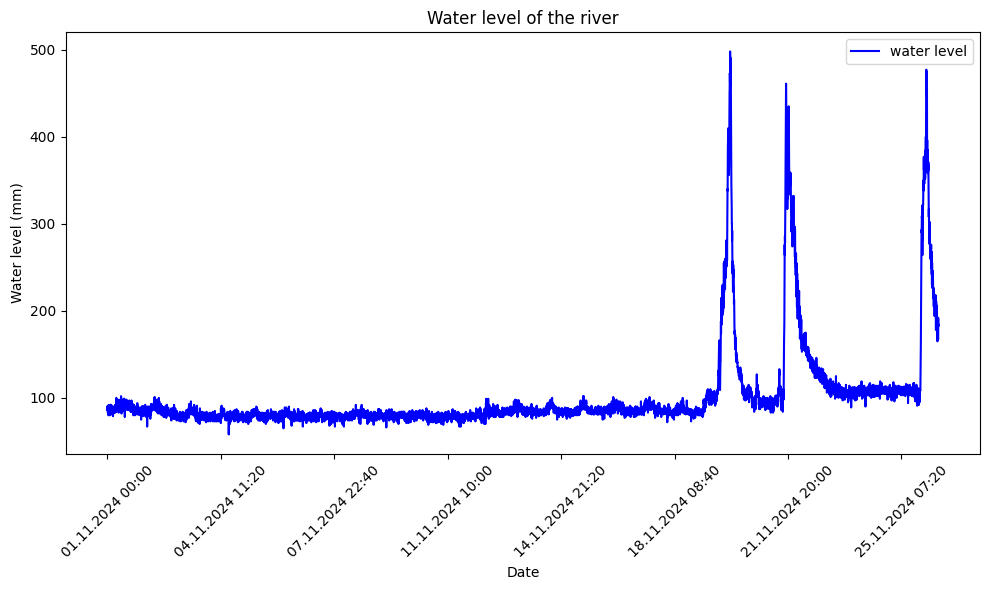

In [26]:
# Plot water level data

plt.figure(figsize=(10, 6))
plt.plot(df_riverlevel['Date'], df_riverlevel['water level (mm)'], label='water level', color='blue')

# Show one every 1000 dates.
plt.xticks(df_riverlevel['Date'][::1000], rotation=45)

plt.xlabel('Date')
plt.ylabel('Water level (mm)')
plt.title('Water level of the river')
plt.legend()

plt.tight_layout()
plt.show()

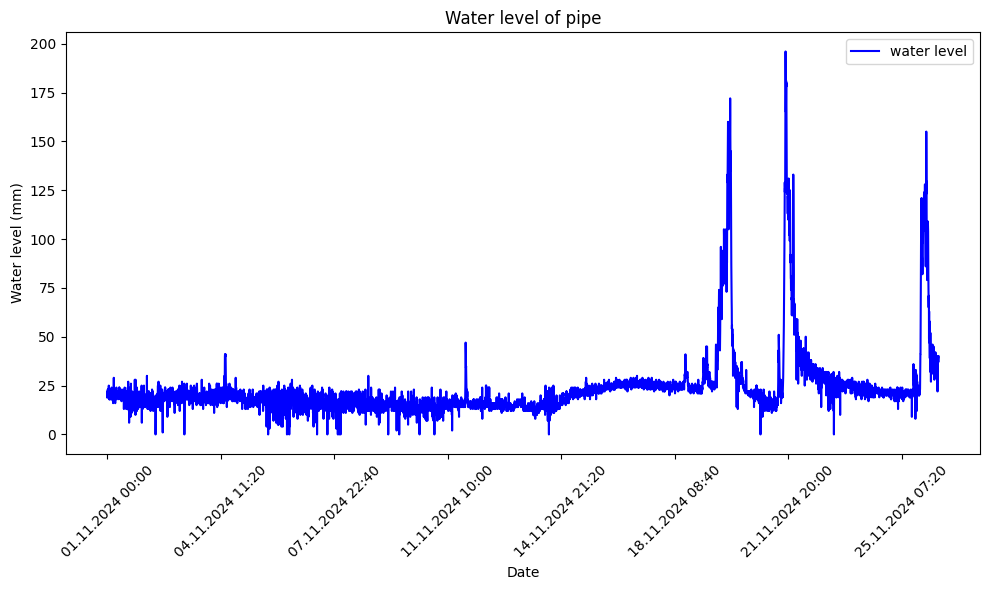

In [27]:
# Water level pipe

plt.figure(figsize=(10, 6))
plt.plot(df_triades['Date'], df_triades['water level (mm)'], label='water level', color='blue')

# Show one every 1000 dates.
plt.xticks(df_triades['Date'][::1000], rotation=45)

plt.xlabel('Date')
plt.ylabel('Water level (mm)')
plt.title('Water level of pipe')
plt.legend()

plt.tight_layout()
plt.show()

#### Water level 2

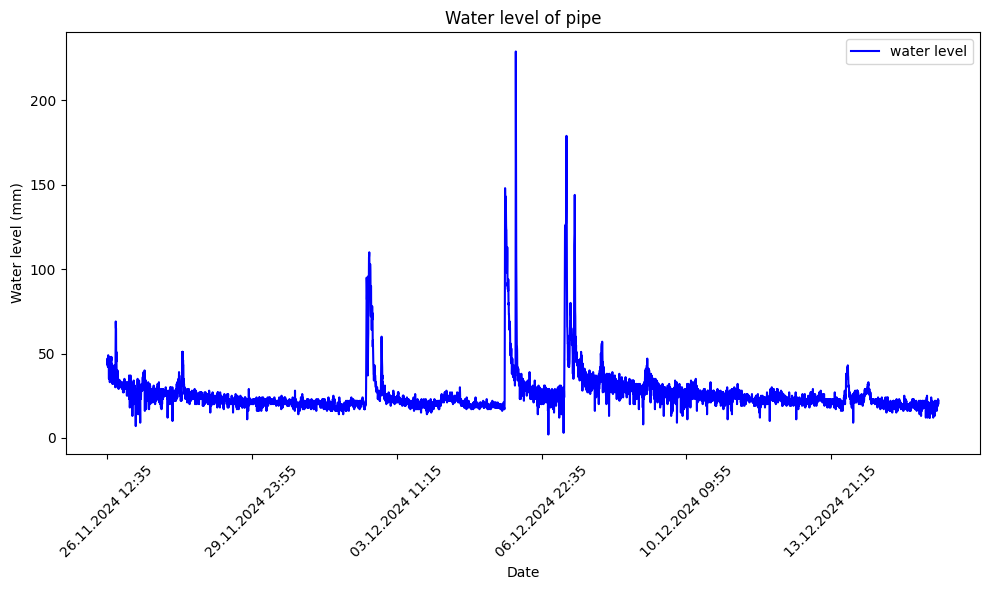

In [28]:
# Water level pipe

plt.figure(figsize=(10, 6))
plt.plot(df_triades2['Date'], df_triades2['water level (mm)'], label='water level', color='blue')

# Show one every 1000 dates.
plt.xticks(df_triades2['Date'][::1000], rotation=45)

plt.xlabel('Date')
plt.ylabel('Water level (mm)')
plt.title('Water level of pipe')
plt.legend()

plt.tight_layout()
plt.show()

#### break

### Conversion

In [29]:
# Conversion from water level to discharge 
# Define the conversion function
def conversion(level):
    if level == 0:
        Qp = 0
    else:
        D = 1.25  # pipe diameter [m]
        ks = 4 / 1000  # roughness coefficient [m]
        phi = 2 * np.pi - 2 * np.arccos((level / 1000 - D / 2) / (D / 2))
        Ad = ((phi - np.sin(phi)) / 8) * D**2
        Pd = phi * D / 2
        Rd = (1 - np.sin(phi)) * D / 4
        Ap = (phi - np.sin(phi)) / (2 * np.pi)
        Rp = 1 - np.sin(phi) / phi
        Vp = (1 + np.log(Rp) / np.log(3.7 * D / ks)) * Rp**0.5
        Qp = (1 + np.log(Rp) / np.log(3.7 * D / ks)) * Ap * Rp**0.5

    return Qp

# Apply the function to the "water level (mm)" column
df_triades['Flow Rate (Qp)'] = df_triades['water level (mm)'].apply(conversion)

# Save df_triades as a pickle file
df_triades.to_pickle('df_triades.pkl')

# Display the updated DataFrame
df_triades.head()

,Date,Sn,Name,temperature,water level (mm),Flow Rate (Qp)
0,01.11.2024 00:00,IJA0102-00006283,Rejet Triaud,12,19,0.000346
1,01.11.2024 00:05,IJA0102-00006283,Rejet Triaud,12,22,0.000481
2,01.11.2024 00:10,IJA0102-00006283,Rejet Triaud,12,20,0.000388
3,01.11.2024 00:15,IJA0102-00006283,Rejet Triaud,12,21,0.000433
4,01.11.2024 00:20,IJA0102-00006283,Rejet Triaud,12,19,0.000346


In [30]:
# Determine the number of rows in each part

# Make a part for each peak measured flow
part1 = df_triades[:5000]
part2 = df_triades[5450:5550] 
part3 = df_triades[5950:6050]
part4 = df_triades[6051:]  # Include the remainder in the last part

# Print lengths to verify
print(f"Length of part1: {len(part1)}")
print(f"Length of part2: {len(part2)}")
print(f"Length of part3: {len(part3)}")
print(f"Length of part4: {len(part4)}")
# Check the column names of part3
np.mean(part1['Flow Rate (Qp)'])

Length of part1: 5000
Length of part2: 100
Length of part3: 100
Length of part4: 1274


0.0003356042075364583

In [31]:
df_triades['Flow Rate (Qp)']

0       0.000346
1       0.000481
2       0.000388
3       0.000433
4       0.000346
          ...   
7320    0.001713
7321    0.001713
7322    0.001811
7323    0.001525
7324    0.001811
Name: Flow Rate (Qp), Length: 7325, dtype: float64

In [32]:
#Only run this one time, to avoid substract the mean multiple time
df_triades['Flow Rate (Qp)'] = df_triades['water level (mm)'].apply(conversion)

#Mean of the 5000 first values
a = 0.000327

df_triades['Flow Rate (Qp)'] = (df_triades['Flow Rate (Qp)'] - a).clip(lower=0)

In [33]:
df_triades['Flow Rate (Qp)']

0       0.000019
1       0.000154
2       0.000061
3       0.000106
4       0.000019
          ...   
7320    0.001386
7321    0.001386
7322    0.001484
7323    0.001198
7324    0.001484
Name: Flow Rate (Qp), Length: 7325, dtype: float64

Figure saved as plot/discharge.png


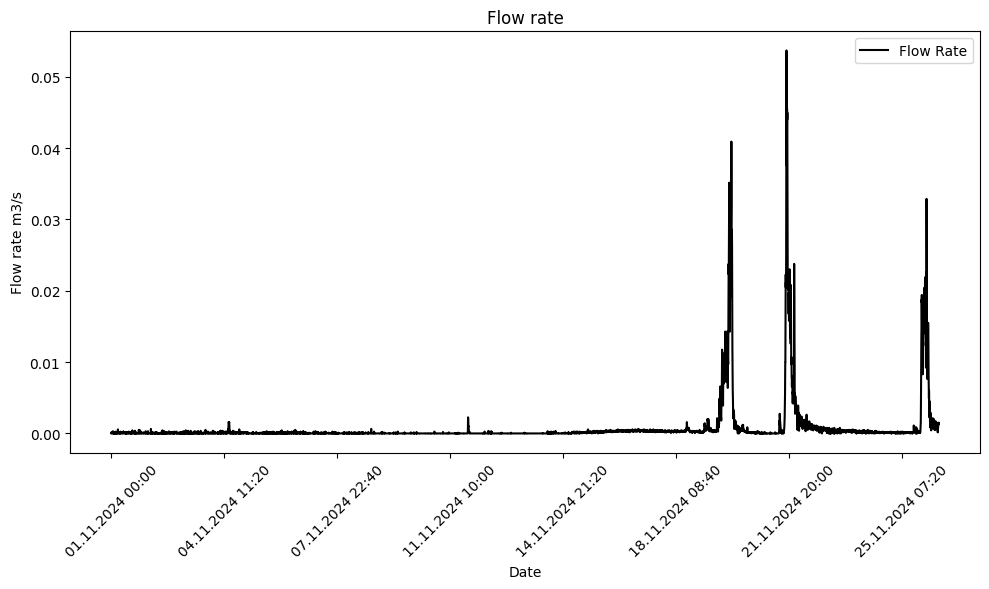

In [34]:
#Flow rate 

plt.figure(figsize=(10, 6))
plt.plot(df_triades['Date'], df_triades['Flow Rate (Qp)'], label='Flow Rate', color='black')

# Show one every 1000 dates.
plt.xticks(df_triades['Date'][::1000], rotation=45)

plt.xlabel('Date')
plt.ylabel('Flow rate m3/s')
plt.title('Flow rate')
plt.legend()


output_file = "plot/discharge.png"  # Define the output file name and format
plt.tight_layout()
plt.savefig(output_file, dpi=300)  # Save with 300 DPI for high quality
print(f"Figure saved as {output_file}")


plt.tight_layout()
plt.show()



In [35]:
# Get the 10 largest Flow Rate (Qp) values and their indices
top_10 = df_triades['Flow Rate (Qp)'].nlargest(10)

# Retrieve the corresponding dates
top_10_dates = df_triades.loc[top_10.index, ['Date', 'Flow Rate (Qp)']]

# Display the results
print("Dates corresponding to the 10 largest flow rates:")
print(top_10_dates)

Dates corresponding to the 10 largest flow rates:
                  Date  Flow Rate (Qp)
5977  21.11.2024 18:05        0.053668
5978  21.11.2024 18:10        0.047609
5982  21.11.2024 18:30        0.045492
5984  21.11.2024 18:40        0.044970
5983  21.11.2024 18:35        0.043935
5981  21.11.2024 18:25        0.041899
5976  21.11.2024 18:00        0.041397
5979  21.11.2024 18:15        0.041397
5489  20.11.2024 01:25        0.040899
5975  21.11.2024 17:55        0.037968


## Calculation of the area under the curves

### Total volume of water in the pipe calculated with conversion function

In [29]:
# Extract Flow Rate values
flow_rate = df_triades['Flow Rate (Qp)'].values

# Time intervals in seconds (5 minutes = 300 seconds)
dx = 300  # seconds

# Calculate the area under the curve using the trapezoidal rule
total_volume = np.trapz(flow_rate, dx=dx)

# Print the result
print(f"Total Volume of Water: {total_volume:.6f} m³")

Total Volume of Water: 1661.361219 m³


In [30]:
#Loading the raining data

with open('df_model_pluvio.pkl','rb') as f:
    df_modeled = pd.read_pickle(f)
df_modeled

,Date,Sn,Name,Compteur[0] (22[0]),precp,Qout,Qroad,Qroof,Qsoil,Qtank,Qbuffer,soil_mois,Vbuffer
0,01.11.2024 00:04,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.310000,0.000000
1,01.11.2024 00:09,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.309941,0.000000
2,01.11.2024 00:14,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.309882,0.000000
3,01.11.2024 00:19,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.309823,0.000000
4,01.11.2024 00:24,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.309764,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7345,26.11.2024 12:09,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000012,2.464237e-14,2.496347e-14,0.0,0.0,0.000012,0.281938,0.000004
7346,26.11.2024 12:14,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000012,1.950854e-14,1.976275e-14,0.0,0.0,0.000012,0.281886,0.000004
7347,26.11.2024 12:19,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000012,1.544426e-14,1.564551e-14,0.0,0.0,0.000012,0.281834,0.000004
7348,26.11.2024 12:24,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000011,1.222671e-14,1.238603e-14,0.0,0.0,0.000011,0.281783,0.000004


In [31]:
df_pluviometer

,Date,Sn,Name,compteur,precp
0,2024-11-01 00:04:00,IJA0102-00009933,Pluvio_Gr,0,0.0
1,2024-11-01 00:09:00,IJA0102-00009933,Pluvio_Gr,0,0.0
2,2024-11-01 00:14:00,IJA0102-00009933,Pluvio_Gr,0,0.0
3,2024-11-01 00:19:00,IJA0102-00009933,Pluvio_Gr,0,0.0
4,2024-11-01 00:24:00,IJA0102-00009933,Pluvio_Gr,0,0.0
...,...,...,...,...,...
7345,2024-11-26 12:09:00,IJA0102-00009933,Pluvio_Gr,0,0.0
7346,2024-11-26 12:14:00,IJA0102-00009933,Pluvio_Gr,0,0.0
7347,2024-11-26 12:19:00,IJA0102-00009933,Pluvio_Gr,0,0.0
7348,2024-11-26 12:24:00,IJA0102-00009933,Pluvio_Gr,0,0.0


In [32]:
# Sum of the precipitation and conversion from mm to m 

pluie = np.sum(df_pluviometer['precp'])/1000

# Multiplying by the impermeable area find by the other student

result = np.sum(pluie) * 24365.7

result = round(result, 2)  # Round to 2 decimal places
print(result)

1642.25


In [33]:
# Extract Flow Rate values
flow_rate = df_modeled['Qout'].values

# Time intervals in seconds (5 minutes = 300 seconds)
dx = 300  # seconds

# Calculate the area under the curve using the trapezoidal rule
total_volume = np.trapz(flow_rate, dx=dx)

# Print the result
print(f"Total Volume of Water: {total_volume:.6f} m³")

Total Volume of Water: 1642.155325 m³


### Constant K

In [34]:
df_model_pluvio = pd.read_pickle('df_model_pluvio.pkl')

df_model_pluvio

,Date,Sn,Name,Compteur[0] (22[0]),precp,Qout,Qroad,Qroof,Qsoil,Qtank,Qbuffer,soil_mois,Vbuffer
0,01.11.2024 00:04,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.310000,0.000000
1,01.11.2024 00:09,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.309941,0.000000
2,01.11.2024 00:14,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.309882,0.000000
3,01.11.2024 00:19,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.309823,0.000000
4,01.11.2024 00:24,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.309764,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7345,26.11.2024 12:09,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000012,2.464237e-14,2.496347e-14,0.0,0.0,0.000012,0.281938,0.000004
7346,26.11.2024 12:14,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000012,1.950854e-14,1.976275e-14,0.0,0.0,0.000012,0.281886,0.000004
7347,26.11.2024 12:19,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000012,1.544426e-14,1.564551e-14,0.0,0.0,0.000012,0.281834,0.000004
7348,26.11.2024 12:24,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000011,1.222671e-14,1.238603e-14,0.0,0.0,0.000011,0.281783,0.000004


In [35]:
df_triades

,Date,Sn,Name,temperature,water level (mm),Flow Rate (Qp)
0,2024-11-01 00:00:00,IJA0102-00006283,Rejet Triaud,12,19,0.000019
1,2024-11-01 00:05:00,IJA0102-00006283,Rejet Triaud,12,22,0.000154
2,2024-11-01 00:10:00,IJA0102-00006283,Rejet Triaud,12,20,0.000061
3,2024-11-01 00:15:00,IJA0102-00006283,Rejet Triaud,12,21,0.000106
4,2024-11-01 00:20:00,IJA0102-00006283,Rejet Triaud,12,19,0.000019
...,...,...,...,...,...,...
7320,2024-11-26 10:00:00,IJA0102-00006283,Rejet Triaud,9,39,0.001386
7321,2024-11-26 10:05:00,IJA0102-00006283,Rejet Triaud,9,39,0.001386
7322,2024-11-26 10:10:00,IJA0102-00006283,Rejet Triaud,10,40,0.001484
7323,2024-11-26 10:15:00,IJA0102-00006283,Rejet Triaud,10,37,0.001198


We need to compare the flow rate in df_triades, to the Q_out of the modelized 

Plot saved as 'Qout_Qmod_1.png'.


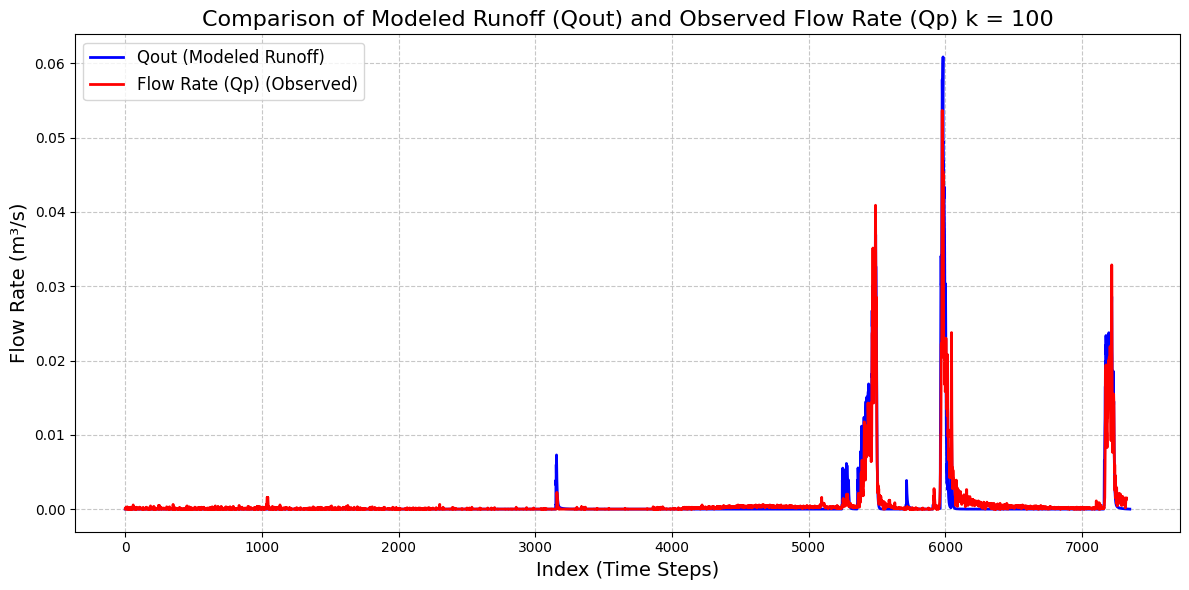

In [36]:
# k = 100

# Ensure both datasets have numeric indices
df_model_pluvio.reset_index(drop=True, inplace=True)
df_triades.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_pluvio.index, df_model_pluvio['Qout'], label="Qout (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades.index, df_triades['Flow Rate (Qp)'], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed Flow Rate (Qp) k = 100", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig("plot/Qout_Qmod_1.png", dpi=300)  # Save as PNG with high quality
print("Plot saved as 'Qout_Qmod_1.png'.")
plt.show()


In [37]:
a = np.max(df_model_pluvio['Qout'])/np.max(df_triades['Flow Rate (Qp)'])

m = 4.262;

k = 100/m

k

23.463162834350072

In [38]:
df_model_pluvio['Qout k=23.42'] = df_model_pluvio['Qout']/m

Plot saved as 'Qout_Qmod.png'.


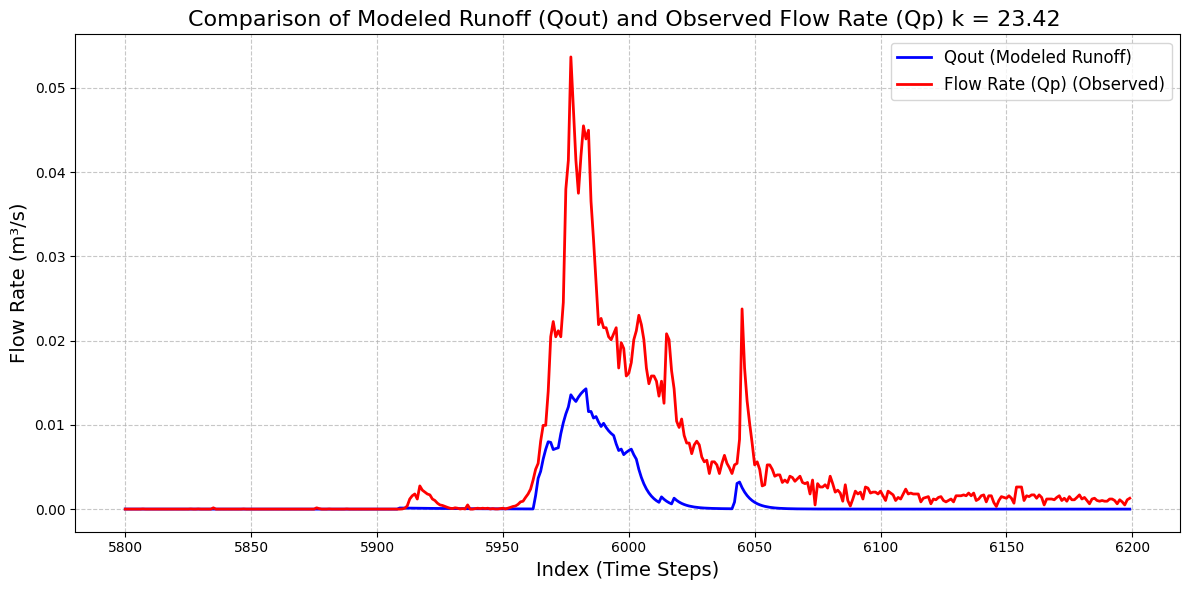

In [39]:
# k = 100/4.262

# Ensure both datasets have numeric indices
df_model_pluvio.reset_index(drop=True, inplace=True)
df_triades.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_pluvio.index[5800:6200], df_model_pluvio['Qout k=23.42'][5800:6200], label="Qout (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades.index[5800:6200], df_triades['Flow Rate (Qp)'][5800:6200], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed Flow Rate (Qp) k = 23.42 ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig("plot/Qout_Qmod.png", dpi=300)  # Save as PNG with high quality
print("Plot saved as 'Qout_Qmod.png'.")
plt.show()

In [40]:
df_triades[6000:6100]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

,Date,Sn,Name,temperature,water level (mm),Flow Rate (Qp)
6000,2024-11-21 20:00:00,IJA0102-00006283,Rejet Triaud,9,111,0.016113
6001,2024-11-21 20:05:00,IJA0102-00006283,Rejet Triaud,9,115,0.017394
6002,2024-11-21 20:10:00,IJA0102-00006283,Rejet Triaud,9,123,0.020103
6003,2024-11-21 20:15:00,IJA0102-00006283,Rejet Triaud,9,126,0.021169
6004,2024-11-21 20:20:00,IJA0102-00006283,Rejet Triaud,9,131,0.023006
...,...,...,...,...,...,...
6095,2024-11-22 03:55:00,IJA0102-00006283,Rejet Triaud,6,49,0.002497
6096,2024-11-22 04:00:00,IJA0102-00006283,Rejet Triaud,6,44,0.001905
6097,2024-11-22 04:05:00,IJA0102-00006283,Rejet Triaud,6,45,0.002017
6098,2024-11-22 04:10:00,IJA0102-00006283,Rejet Triaud,6,45,0.002017


In [41]:
# I cut the modeled to have the same number of sample

modeled_cut = df_model_pluvio[:7325]

modeled_cut

,Date,Sn,Name,Compteur[0] (22[0]),precp,Qout,Qroad,Qroof,Qsoil,Qtank,Qbuffer,soil_mois,Vbuffer,Qout k=23.42
0,01.11.2024 00:04,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.310000,0.000000,0.000000
1,01.11.2024 00:09,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.309941,0.000000,0.000000
2,01.11.2024 00:14,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.309882,0.000000,0.000000
3,01.11.2024 00:19,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.309823,0.000000,0.000000
4,01.11.2024 00:24,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000,0.309764,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7320,26.11.2024 10:04,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000030,8.474683e-12,8.585112e-12,0.0,0.0,0.000030,0.283237,0.000011,0.000007
7321,26.11.2024 10:09,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000029,6.709124e-12,6.796547e-12,0.0,0.0,0.000029,0.283185,0.000010,0.000007
7322,26.11.2024 10:14,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000028,5.311390e-12,5.380600e-12,0.0,0.0,0.000028,0.283133,0.000010,0.000007
7323,26.11.2024 10:19,IJA0102-00009933,Pluvio_Gr,0,0.0,0.000027,4.204851e-12,4.259641e-12,0.0,0.0,0.000027,0.283081,0.000010,0.000006


In [42]:
mean = np.mean(modeled_cut['Qout k=23.42'])/np.mean(df_triades['Flow Rate (Qp)'])

mean

0.23187024214940588

In [43]:
k_2 = k/mean

k_2

101.19091875201283

In [44]:
#We test a new k where the two means are equal.

modeled_cut['Qout k=26.57'] = modeled_cut['Qout k=23.42']/mean

/tmp/ipykernel_120/1809011975.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modeled_cut['Qout k=26.57'] = modeled_cut['Qout k=23.42']/mean


Plot saved as 'Qout_Qmod.png'.


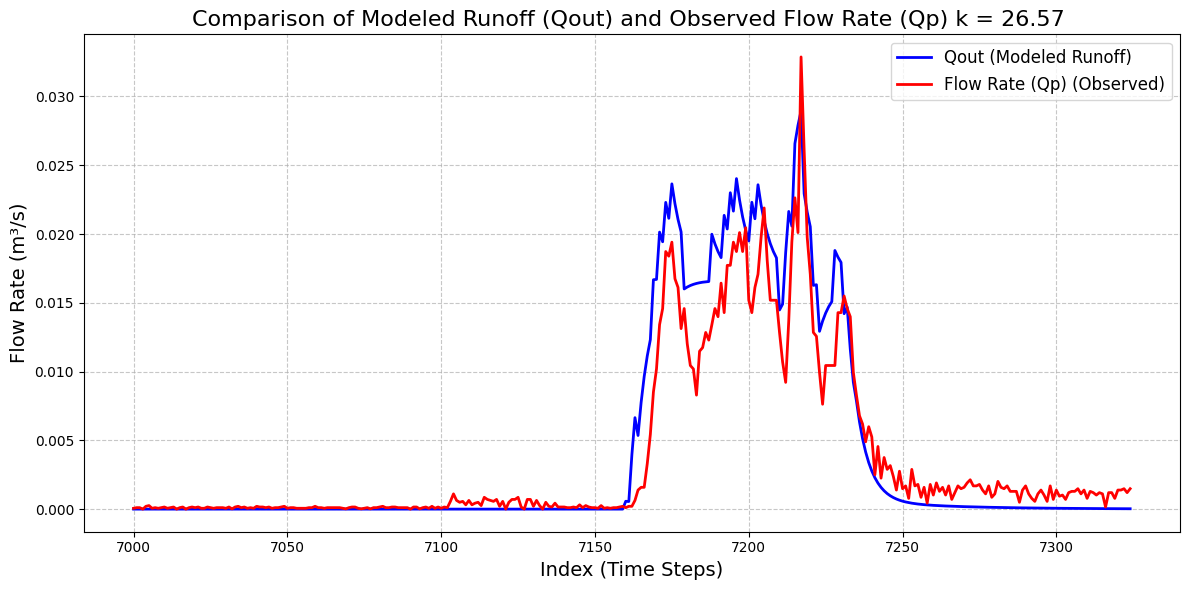

In [45]:
# Ensure both datasets have numeric indices
modeled_cut.reset_index(drop=True, inplace=True)
df_triades.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(modeled_cut.index[7000:], modeled_cut['Qout k=26.57'][7000:], label="Qout (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades.index[7000:], df_triades['Flow Rate (Qp)'][7000:], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed Flow Rate (Qp) k = 26.57 ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig("plot/Qout_Qmod_k26.png", dpi=300)  # Save as PNG with high quality
print("Plot saved as 'Qout_Qmod.png'.")
plt.show()

In [46]:
# Ensure both datasets have numeric indices
modeled_cut.reset_index(drop=True, inplace=True)
df_triades.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(modeled_cut.index[7150:7250], modeled_cut['Qout k=20.16'][7150:7250], label="Qout (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades.index[7150:7250], df_triades['Flow Rate (Qp)'][7150:7250], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of event 3 with k = 20.16 ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig("plot/Event3_k20.png", dpi=300)  # Save as PNG with high quality
print("Plot saved as 'Event3_k20.png'.")
plt.show()

KeyError: 'Qout k=20.16'

<Figure size 1200x600 with 0 Axes>

### Work on the data until 16/12

In [47]:
df_triades2['Flow Rate (Qp)'] = df_triades2['water level (mm)'].apply(conversion)

# Save df_triades as a pickle file
df_triades2.to_pickle('triades2.pkl')

# Display the updated DataFrame
df_triades2

,Date,Sn,Name,water level (mm),Flow Rate (Qp)
0,26.11.2024 12:35,IJA0102-00006283,Rejet Triaud,44,0.002232
1,26.11.2024 12:40,IJA0102-00006283,Rejet Triaud,47,0.002578
2,26.11.2024 12:45,IJA0102-00006283,Rejet Triaud,46,0.002460
3,26.11.2024 12:50,IJA0102-00006283,Rejet Triaud,43,0.002122
4,26.11.2024 12:55,IJA0102-00006283,Rejet Triaud,46,0.002460
...,...,...,...,...,...
5737,16.12.2024 10:40,IJA0102-00006283,Rejet Triaud,19,0.000346
5738,16.12.2024 10:45,IJA0102-00006283,Rejet Triaud,23,0.000531
5739,16.12.2024 10:50,IJA0102-00006283,Rejet Triaud,20,0.000388
5740,16.12.2024 10:55,IJA0102-00006283,Rejet Triaud,20,0.000388


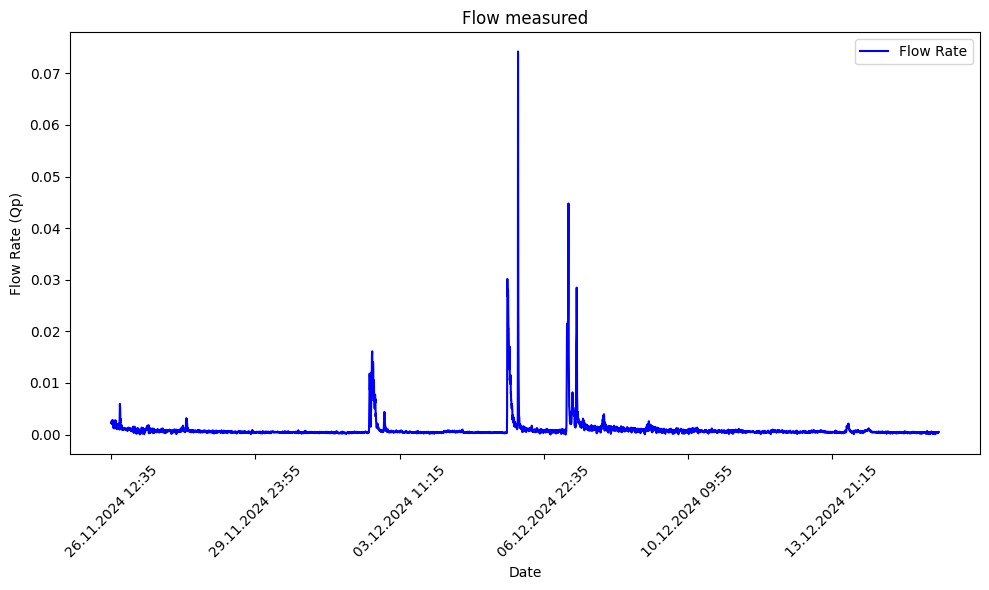

In [48]:
# Flow 

plt.figure(figsize=(10, 6))
plt.plot(df_triades2['Date'], df_triades2['Flow Rate (Qp)'], label='Flow Rate', color='blue')

# Show one every 1000 dates.
plt.xticks(df_triades2['Date'][::1000], rotation=45)

plt.xlabel('Date')
plt.ylabel('Flow Rate (Qp)')
plt.title('Flow measured')
plt.legend()

plt.tight_layout()
plt.show()

#### isolation of the peak

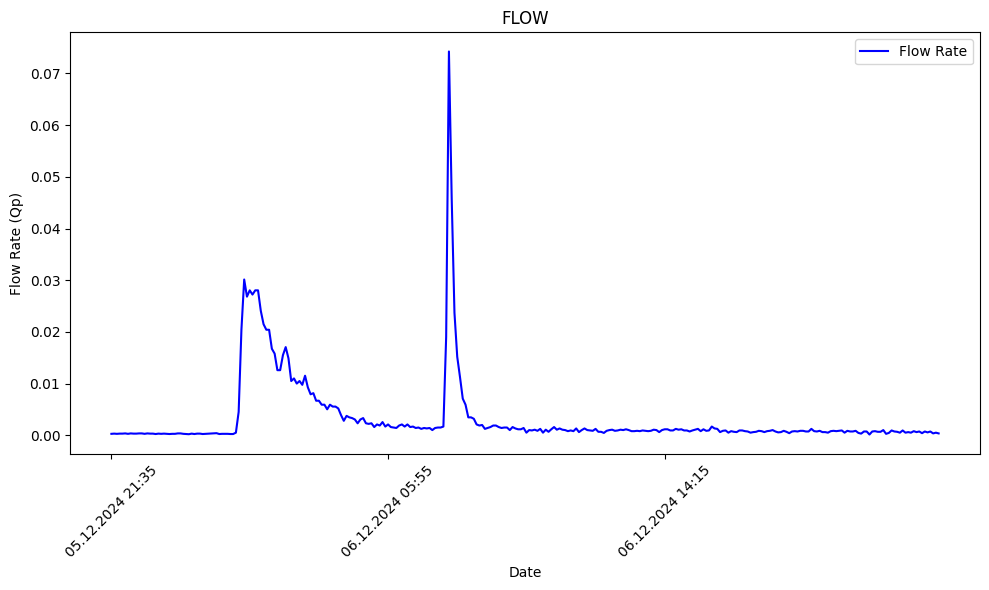

In [49]:
# Flow 

plt.figure(figsize=(10, 6))
plt.plot(df_triades2['Date'][2700:3000], df_triades2['Flow Rate (Qp)'][2700:3000], label='Flow Rate', color='blue')

# Show one every 1000 dates.
plt.xticks(df_triades2['Date'][2700:3000:100], rotation=45)

plt.xlabel('Date')
plt.ylabel('Flow Rate (Qp)')
plt.title('FLOW')
plt.legend()

plt.tight_layout()
plt.show()

In [50]:
#Create a copy to modify the peak that is causing problem

df_triades2['Flow Rate Copy'] = df_triades2['Flow Rate (Qp)']

# Use .loc[] to modify the specific range of rows
#df_triades2.loc[2847:2851, 'Flow Rate Copy'] = df_triades2.loc[2847:2851, 'Flow Rate Copy'] / 3


In [51]:
df_model_2 = pd.read_pickle('df_model_2.pkl')

In [52]:
df_model_2

,Date,Sn,Name,compteur,precp,precp2,Qout,Qroad,Qroof,Qsoil,Qtank,Qbuffer,soil_mois,Vbuffer
0,26.11.2024 12:35,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.310000,0.000000e+00
1,26.11.2024 12:40,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.309941,0.000000e+00
2,26.11.2024 12:45,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.309882,0.000000e+00
3,26.11.2024 12:50,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.309823,0.000000e+00
4,26.11.2024 12:55,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.309764,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5737,16.12.2024 10:40,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0,2.393529e-11,3.574975e-53,3.621559e-53,0.0,0.0,2.393529e-11,0.189067,8.487379e-12
5738,16.12.2024 10:45,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0,2.310421e-11,2.830189e-53,2.867067e-53,0.0,0.0,2.310421e-11,0.189039,8.192679e-12
5739,16.12.2024 10:50,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0,2.230198e-11,2.240566e-53,2.269762e-53,0.0,0.0,2.230198e-11,0.189011,7.908211e-12
5740,16.12.2024 10:55,IJA0102-00009933,Pluvio_Gr,0,0.0,0.0,2.152760e-11,1.773782e-53,1.796895e-53,0.0,0.0,2.152760e-11,0.188984,7.633620e-12


#### plot

Figure saved as plot/pluie.png


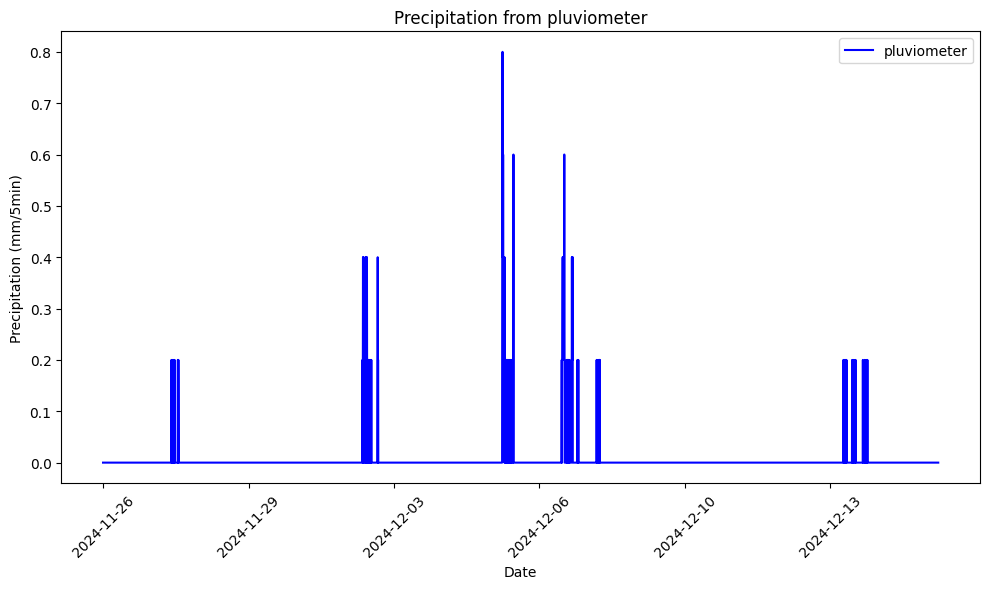

In [53]:
# rain data 

# Plot precipitation data

plt.figure(figsize=(10, 6))
plt.plot(df_pluvio_2['Date'], df_pluvio_2['precp'], label='pluviometer', color='blue')

# Show one every 1000 dates.
plt.xticks(df_pluvio_2['Date'][::1000], rotation=45)

plt.xlabel('Date')
plt.ylabel('Precipitation (mm/5min)')
plt.title('Precipitation from pluviometer')
plt.legend()

output_file = "plot/pluie.png"  # Define the output file name and format
plt.tight_layout()
plt.savefig(output_file, dpi=300)  # Save with 300 DPI for high quality
print(f"Figure saved as {output_file}")


plt.tight_layout()
plt.show()


Figure saved as plot/qout.png


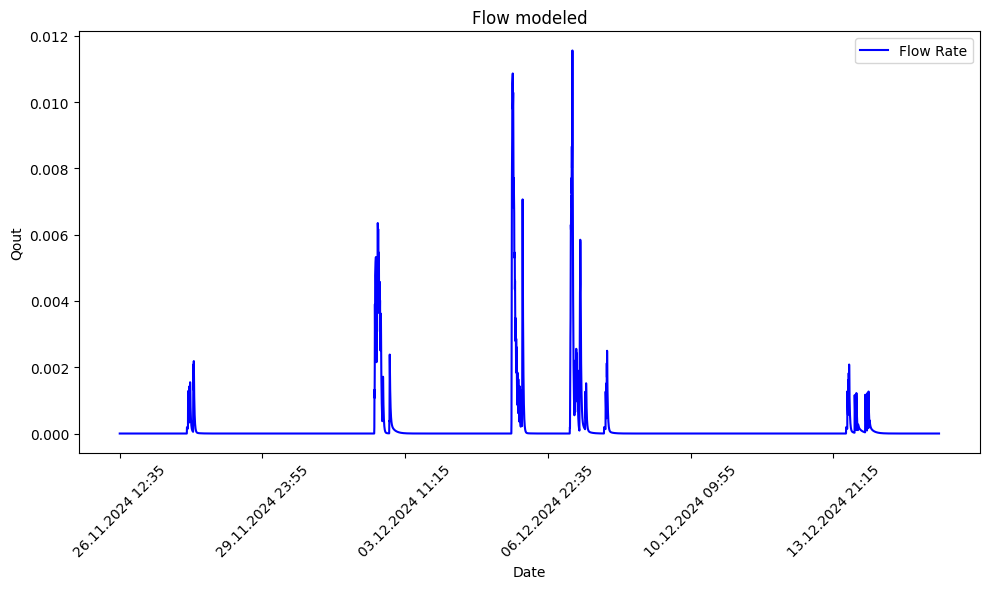

In [54]:
plt.figure(figsize=(10, 6))

df_model_2 = pd.read_pickle('df_model_2.pkl')

df_model_2['Qout'] = df_model_2['Qout']*20.16/60

plt.plot(df_model_2['Date'], df_model_2['Qout'], label='Flow Rate', color='blue')

# Show one every 1000 dates.
plt.xticks(df_model_2['Date'][::1000], rotation=45)

plt.xlabel('Date')
plt.ylabel('Qout')
plt.title('Flow modeled')
plt.legend()
output_file = "plot/qout.png"  # Define the output file name and format
plt.tight_layout()
plt.savefig(output_file, dpi=300)  # Save with 300 DPI for high quality
print(f"Figure saved as {output_file}")


plt.tight_layout()
plt.show()

In [55]:
np.mean(df_model_2['Qout'])

0.0001634903673630991

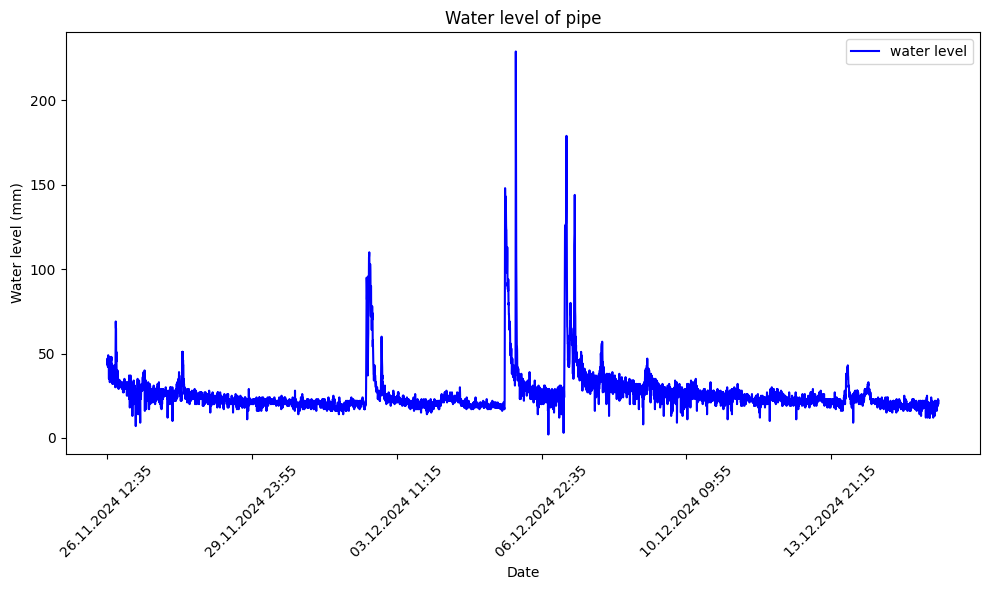

In [56]:
# Water level pipe

plt.figure(figsize=(10, 6))
plt.plot(df_triades2['Date'], df_triades2['water level (mm)'], label='water level', color='blue')

# Show one every 1000 dates.
plt.xticks(df_triades2['Date'][::1000], rotation=45)

plt.xlabel('Date')
plt.ylabel('Water level (mm)')
plt.title('Water level of pipe')
plt.legend()

plt.tight_layout()
plt.show()

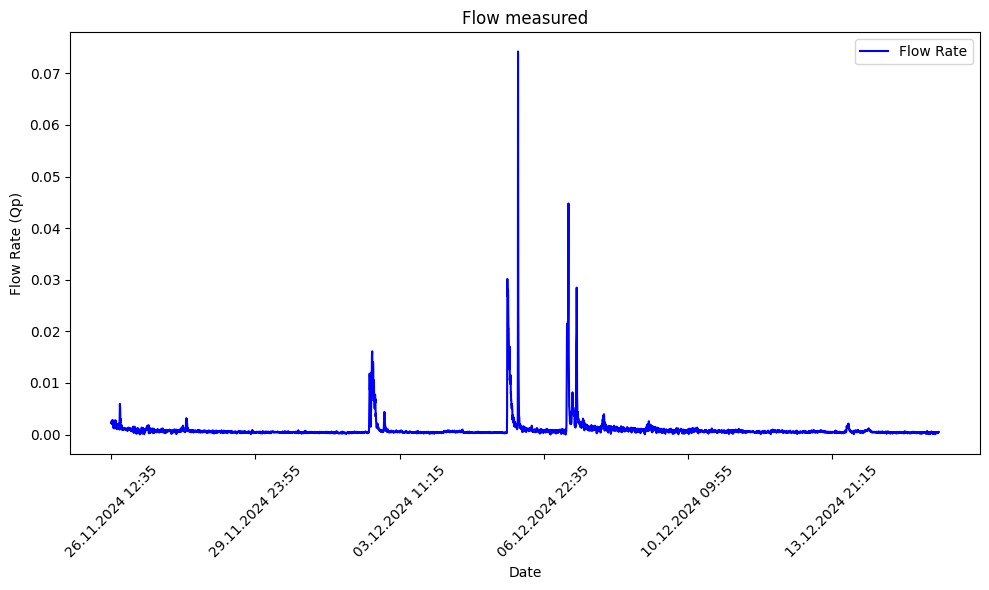

In [57]:
# Flow 

plt.figure(figsize=(10, 6))
plt.plot(df_triades2['Date'], df_triades2['Flow Rate (Qp)'], label='Flow Rate', color='blue')

# Show one every 1000 dates.
plt.xticks(df_triades2['Date'][::1000], rotation=45)

plt.xlabel('Date')
plt.ylabel('Flow Rate (Qp)')
plt.title('Flow measured')
plt.legend()

plt.tight_layout()
plt.show()

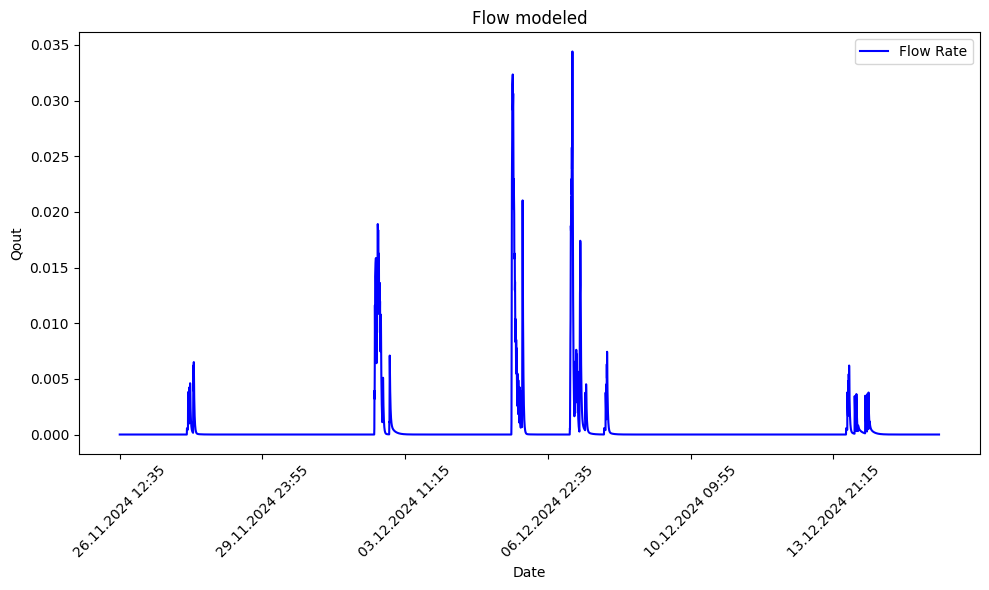

In [58]:
plt.figure(figsize=(10, 6))

df_model_2 = pd.read_pickle('df_model_2.pkl')

df_model_2['Qout'] = df_model_2['Qout']

df_model_2['Qout_k16']= df_model_2['Qout']

plt.plot(df_model_2['Date'], df_model_2['Qout'], label='Flow Rate', color='blue')

# Show one every 1000 dates.
plt.xticks(df_model_2['Date'][::1000], rotation=45)

plt.xlabel('Date')
plt.ylabel('Qout')
plt.title('Flow modeled')
plt.legend()

plt.tight_layout()
plt.show()

#### Trying to see what's wrong with the model

In [ ]:
# Assuming 'precp' is rainfall and 'Qout' is flow rate in your DataFrame
rainfall = df_pluvio_2['precp']
flow = df_model_2['Qout']

# Compute cross-correlation
lags = range(-50, 50)  # Test lags between -50 and +50 time steps
cross_corr = [rainfall.shift(lag).corr(flow) for lag in lags]

# Plot the cross-correlation
plt.plot(lags, cross_corr, color='blue')
plt.title('Cross-correlation between Rainfall and Qout')
plt.xlabel('Lag (time steps)')
plt.ylabel('Correlation')

output_file = "plot/corr.png"  # Define the output file name and format
plt.tight_layout()
plt.savefig(output_file, dpi=300)  # Save with 300 DPI for high quality
print(f"Figure saved as {output_file}")


plt.grid()
plt.show()

In [ ]:
df_model_2

In [ ]:
# Ensure both datasets have numeric indices
df_model_2.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_2.index, df_model_2['Qout'], label="Qout (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index, df_triades2['Flow Rate Copy'], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig("plot/model2.png", dpi=300)  # Save as PNG with high quality
print("Plot saved as 'model2.png'.")
plt.show()

In [ ]:
# Ensure both datasets have numeric indices
df_model_2.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_2.index, df_model_2['Qout_k16'], label="Qout (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index, df_triades2['Flow Rate (Qp)'], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) k=16 and Observed Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig("plot/modelk10.png", dpi=300)  # Save as PNG with high quality
print("Plot saved as 'modelk10.png'.")
plt.show()

In [ ]:
# Ensure both datasets have numeric indices
df_model_2.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_2.index[2700:3000], df_model_2['Qout_k16'][2700:3000], label="Qout (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index[2700:3000], df_triades2['Flow Rate (Qp)'][2700:3000], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) k=16 and Observed Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Ensure both datasets have numeric indices
df_model_2.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_2.index[3100:3500], df_model_2['Qout_k16'][3100:3500], label="Qout (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index[3100:3500], df_triades2['Flow Rate (Qp)'][3100:3500], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) k=16 and Observed Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:

# Ensure both datasets have numeric indices
df_pluvio_2.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)


# Create a new figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot precipitation data on the first y-axis
ax1.plot(df_pluvio_2.index, df_pluvio_2['precp'], label='Precipitation (Pluviometer)', color='blue')
ax1.set_xlabel('index')
ax1.set_ylabel('Precipitation (mm/5min)', color='blue')  # Set y-label for precipitation
ax1.tick_params(axis='y', labelcolor='blue')  # Make tick labels blue

# Create a second y-axis for flow rate
ax2 = ax1.twinx()  # This creates a second y-axis that shares the same x-axis
ax2.plot(df_triades2.index, df_triades2['Flow Rate (Qp)'], label='Flow Rate observed', color='green')
ax2.set_ylabel('Flow Rate (Qp)', color='green')  # Set y-label for flow rate
ax2.tick_params(axis='y', labelcolor='green')  # Make tick labels green

# Adjust x-ticks to show one every 100 dates
ax1.set_xticks(df_pluvio_2.index[::1000])
ax1.tick_params(axis='x', rotation=45)

# Add title and legends
plt.title('Precipitation and Flow Rate')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Tight layout to avoid overlap and save the plot
plt.tight_layout()
plt.savefig('plot/precp_flow.png', dpi=300)  # Save with 300 DPI for high quality
print("Figure saved as precp_flow.png")

# Show the plot
plt.show()


#### Events

Figure saved as e1.png


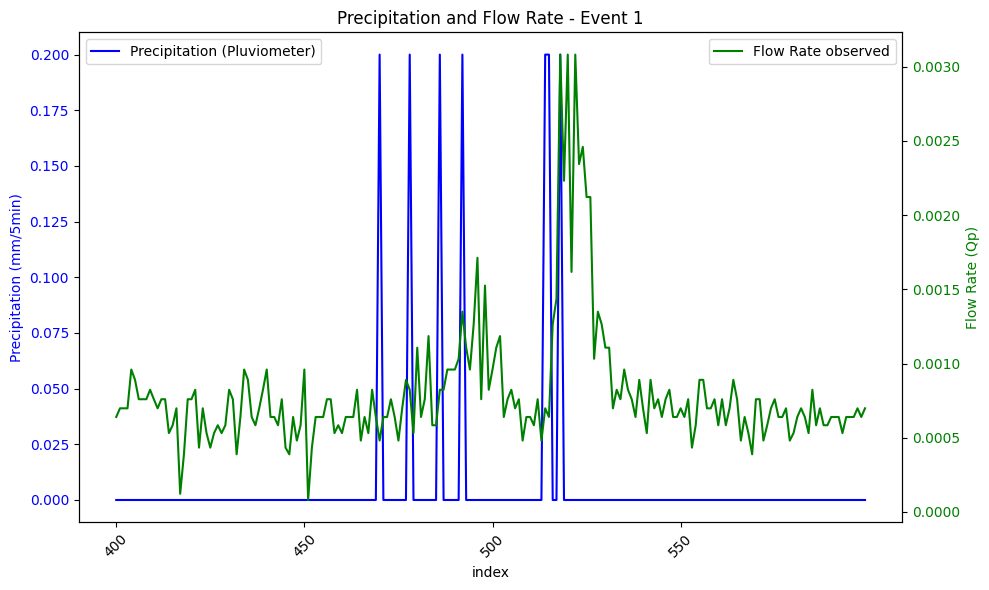

In [59]:

# Ensure both datasets have numeric indices
df_pluvio_2.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)


# Create a new figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot precipitation data on the first y-axis
ax1.plot(df_pluvio_2.index[400:600], df_pluvio_2['precp'][400:600], label='Precipitation (Pluviometer)', color='blue')
ax1.set_xlabel('index')
ax1.set_ylabel('Precipitation (mm/5min)', color='blue')  # Set y-label for precipitation
ax1.tick_params(axis='y', labelcolor='blue')  # Make tick labels blue

# Create a second y-axis for flow rate
ax2 = ax1.twinx()  # This creates a second y-axis that shares the same x-axis
ax2.plot(df_triades2.index[400:600], df_triades2['Flow Rate (Qp)'][400:600], label='Flow Rate observed', color='green')
ax2.set_ylabel('Flow Rate (Qp)', color='green')  # Set y-label for flow rate
ax2.tick_params(axis='y', labelcolor='green')  # Make tick labels green

# Adjust x-ticks to show one every 100 dates
ax1.set_xticks(df_pluvio_2.index[400:600:50])
ax1.tick_params(axis='x', rotation=45)

# Add title and legends
plt.title('Precipitation and Flow Rate - Event 1')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Tight layout to avoid overlap and save the plot
plt.tight_layout()
plt.savefig('plot/e1.png', dpi=300)  # Save with 300 DPI for high quality
print("Figure saved as e1.png")

# Show the plot
plt.show()


event 2

Figure saved as e2.png


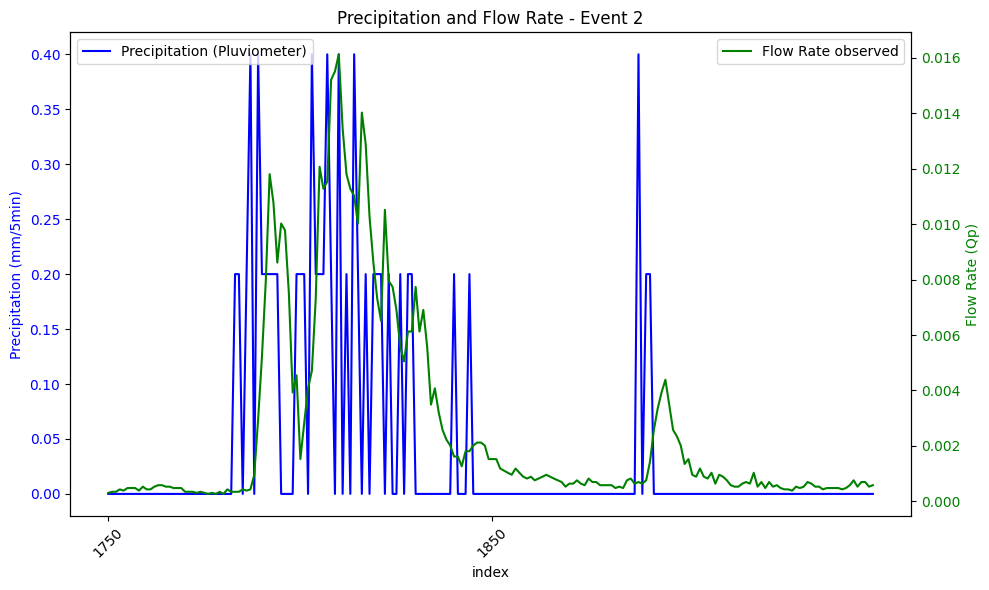

In [60]:

# Ensure both datasets have numeric indices
df_pluvio_2.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)


# Create a new figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot precipitation data on the first y-axis
ax1.plot(df_pluvio_2.index[1750:1950], df_pluvio_2['precp'][1750:1950], label='Precipitation (Pluviometer)', color='blue')
ax1.set_xlabel('index')
ax1.set_ylabel('Precipitation (mm/5min)', color='blue')  # Set y-label for precipitation
ax1.tick_params(axis='y', labelcolor='blue')  # Make tick labels blue

# Create a second y-axis for flow rate
ax2 = ax1.twinx()  # This creates a second y-axis that shares the same x-axis
ax2.plot(df_triades2.index[1750:1950], df_triades2['Flow Rate (Qp)'][1750:1950], label='Flow Rate observed', color='green')
ax2.set_ylabel('Flow Rate (Qp)', color='green')  # Set y-label for flow rate
ax2.tick_params(axis='y', labelcolor='green')  # Make tick labels green

# Adjust x-ticks to show one every 100 dates
ax1.set_xticks(df_pluvio_2.index[1750:1950:100])
ax1.tick_params(axis='x', rotation=45)

# Add title and legends
plt.title('Precipitation and Flow Rate - Event 2')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Tight layout to avoid overlap and save the plot
plt.tight_layout()
plt.savefig('plot/e2.png', dpi=300)  # Save with 300 DPI for high quality
print("Figure saved as e2.png")

# Show the plot
plt.show()


Figure saved as combined_plot_with_two_yaxes.png


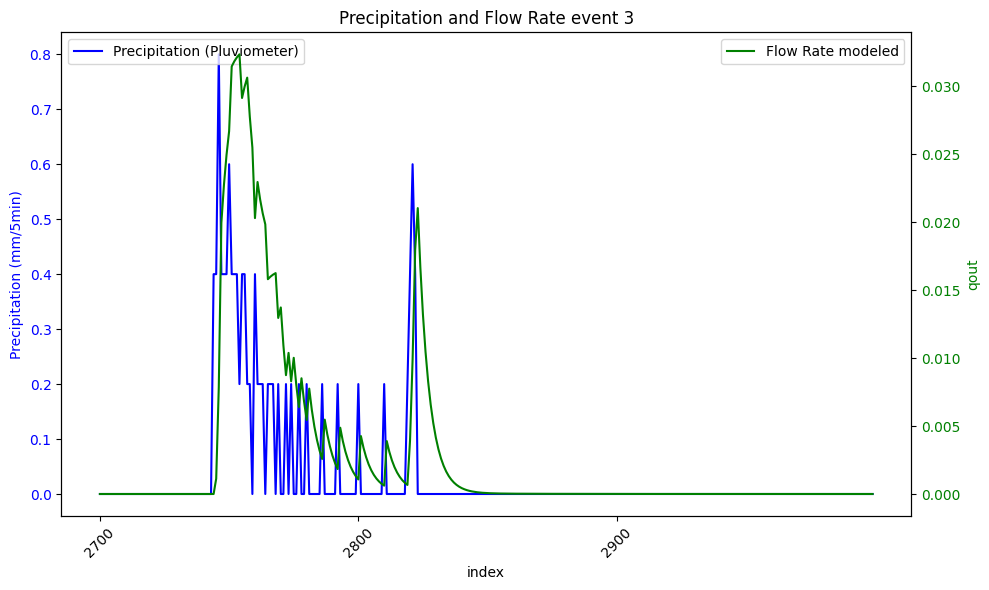

In [61]:

# Ensure both datasets have numeric indices
df_pluvio_2.reset_index(drop=True, inplace=True)
df_model_2.reset_index(drop=True, inplace=True)


# Create a new figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot precipitation data on the first y-axis
ax1.plot(df_pluvio_2.index[2700:3000], df_pluvio_2['precp'][2700:3000], label='Precipitation (Pluviometer)', color='blue')
ax1.set_xlabel('index')
ax1.set_ylabel('Precipitation (mm/5min)', color='blue')  # Set y-label for precipitation
ax1.tick_params(axis='y', labelcolor='blue')  # Make tick labels blue

# Create a second y-axis for flow rate
ax2 = ax1.twinx()  # This creates a second y-axis that shares the same x-axis
ax2.plot(df_model_2.index[2700:3000], df_model_2['Qout'][2700:3000], label='Flow Rate modeled', color='green')
ax2.set_ylabel('qout', color='green')  # Set y-label for flow rate
ax2.tick_params(axis='y', labelcolor='green')  # Make tick labels green

# Adjust x-ticks to show one every 100 dates
ax1.set_xticks(df_pluvio_2.index[2700:3000:100])
ax1.tick_params(axis='x', rotation=45)

# Add title and legends
plt.title('Precipitation and Flow Rate event 3')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Tight layout to avoid overlap and save the plot
plt.tight_layout()
plt.savefig('plot/e3.png', dpi=300)  # Save with 300 DPI for high quality
print("Figure saved as combined_plot_with_two_yaxes.png")

# Show the plot
plt.show()


Figure saved as e4.png


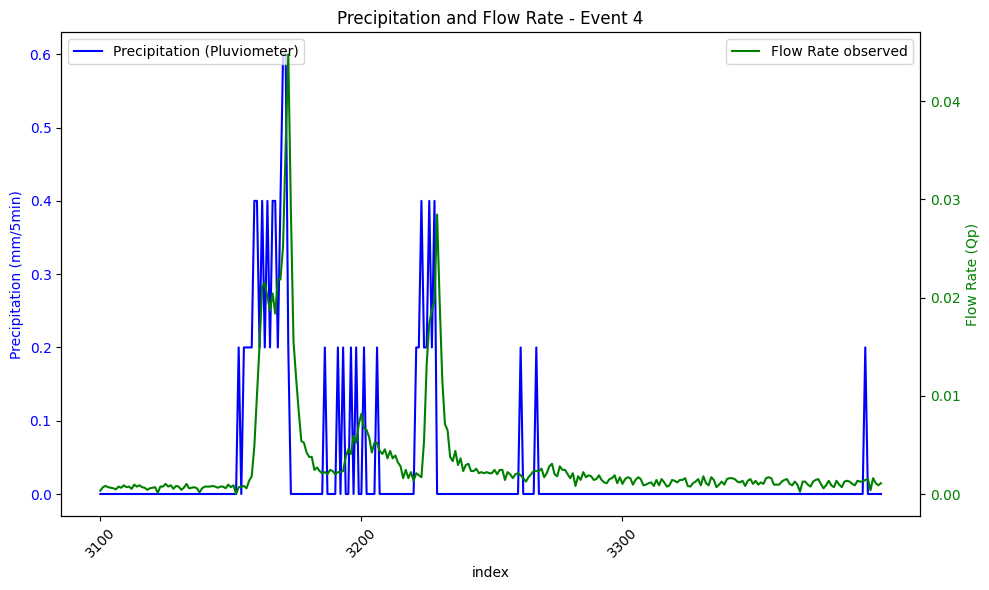

In [62]:

# Ensure both datasets have numeric indices
df_pluvio_2.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)


# Create a new figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot precipitation data on the first y-axis
ax1.plot(df_pluvio_2.index[3100:3400], df_pluvio_2['precp'][3100:3400], label='Precipitation (Pluviometer)', color='blue')
ax1.set_xlabel('index')
ax1.set_ylabel('Precipitation (mm/5min)', color='blue')  # Set y-label for precipitation
ax1.tick_params(axis='y', labelcolor='blue')  # Make tick labels blue

# Create a second y-axis for flow rate
ax2 = ax1.twinx()  # This creates a second y-axis that shares the same x-axis
ax2.plot(df_triades2.index[3100:3400], df_triades2['Flow Rate (Qp)'][3100:3400], label='Flow Rate observed', color='green')
ax2.set_ylabel('Flow Rate (Qp)', color='green')  # Set y-label for flow rate
ax2.tick_params(axis='y', labelcolor='green')  # Make tick labels green

# Adjust x-ticks to show one every 100 dates
ax1.set_xticks(df_pluvio_2.index[3100:3400:100])
ax1.tick_params(axis='x', rotation=45)

# Add title and legends
plt.title('Precipitation and Flow Rate - Event 4')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Tight layout to avoid overlap and save the plot
plt.tight_layout()
plt.savefig('plot/e4.png', dpi=300)  # Save with 300 DPI for high quality
print("Figure saved as e4.png")

# Show the plot
plt.show()


Figure saved as e5.png


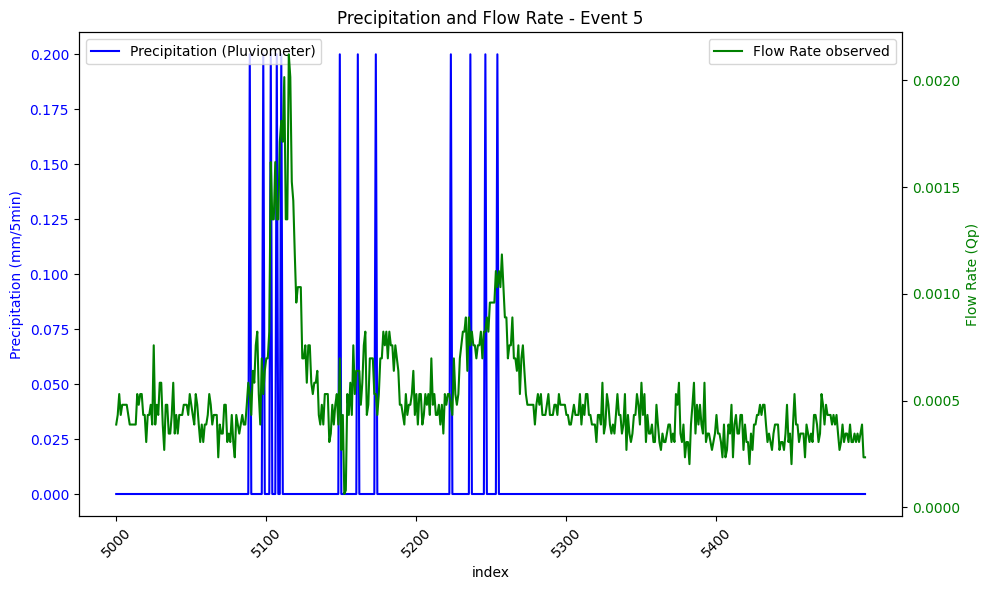

In [63]:

# Ensure both datasets have numeric indices
df_pluvio_2.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)


# Create a new figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot precipitation data on the first y-axis
ax1.plot(df_pluvio_2.index[5000:5500], df_pluvio_2['precp'][5000:5500], label='Precipitation (Pluviometer)', color='blue')
ax1.set_xlabel('index')
ax1.set_ylabel('Precipitation (mm/5min)', color='blue')  # Set y-label for precipitation
ax1.tick_params(axis='y', labelcolor='blue')  # Make tick labels blue

# Create a second y-axis for flow rate
ax2 = ax1.twinx()  # This creates a second y-axis that shares the same x-axis
ax2.plot(df_triades2.index[5000:5500], df_triades2['Flow Rate (Qp)'][5000:5500], label='Flow Rate observed', color='green')
ax2.set_ylabel('Flow Rate (Qp)', color='green')  # Set y-label for flow rate
ax2.tick_params(axis='y', labelcolor='green')  # Make tick labels green

# Adjust x-ticks to show one every 100 dates
ax1.set_xticks(df_pluvio_2.index[5000:5500:100])
ax1.tick_params(axis='x', rotation=45)

# Add title and legends
plt.title('Precipitation and Flow Rate - Event 5')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Tight layout to avoid overlap and save the plot
plt.tight_layout()
plt.savefig('plot/e5.png', dpi=300)  # Save with 300 DPI for high quality
print("Figure saved as e5.png")

# Show the plot
plt.show()


### Work on the proposition of Pr Perona

My try

#### test volume

In [70]:
# Sum of the precipitation and conversion from mm to m 

pluie2 = np.sum(df_pluvio_2['precp'])/1000

# Multiplying by the impermeable area find by the other student

result = np.sum(pluie2) * 24365.7

result = round(result, 2)  # Round to 2 decimal places
print(result)

838.18


### Rainfall correction

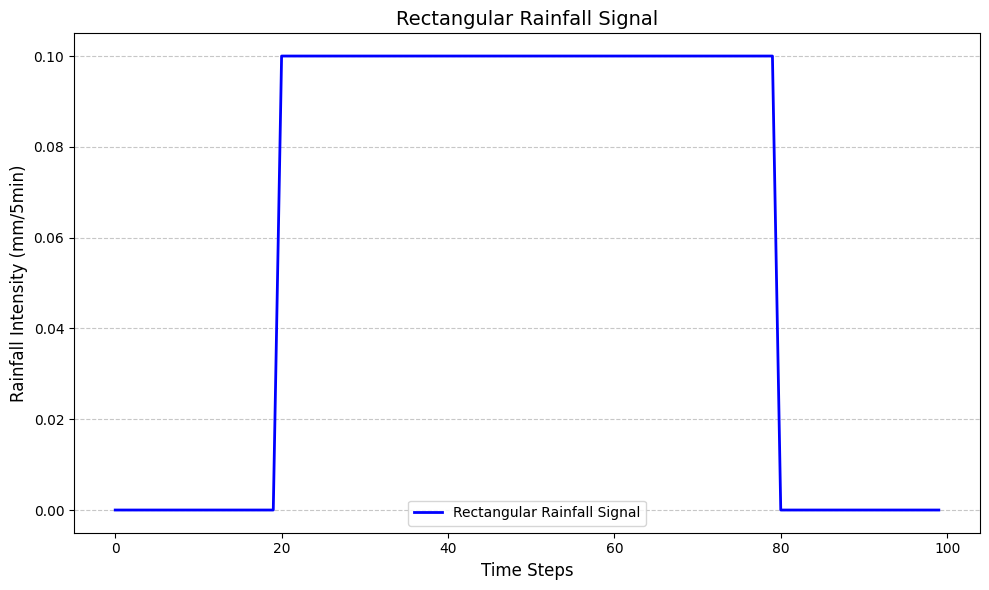

In [11]:

# rectangular signal
def create_rectangular_rainfall_signal(duration=100, intensity=5, start=20, end=80):
    """
    Create a rectangular rainfall signal.

    Parameters:
    - duration: number of time step.
    - intensity: Rainfall intensity during the rectangular event (in mm/5min).
    - start: Start time step of the rainfall event.
    - end: End time step of the rainfall event.

    Returns:
    - rainfall: An array containing the rectangular rainfall signal.
    - time: An array containing the time steps.
    """
    time = np.arange(duration)
    rainfall = np.zeros_like(time, dtype=float)
    rainfall[start:end] = intensity  # Create the rectangular rainfall signal
    return time, rainfall

# Generate a rectangular rainfall signal
time, rainfall = create_rectangular_rainfall_signal(duration=100, intensity=0.1, start=20, end=80)

# Plot the rectangular rainfall signal
plt.figure(figsize=(10, 6))
plt.plot(time, rainfall, label="Rectangular Rainfall Signal", color="blue", linewidth=2)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Rainfall Intensity (mm/5min)", fontsize=12)
plt.title("Rectangular Rainfall Signal", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


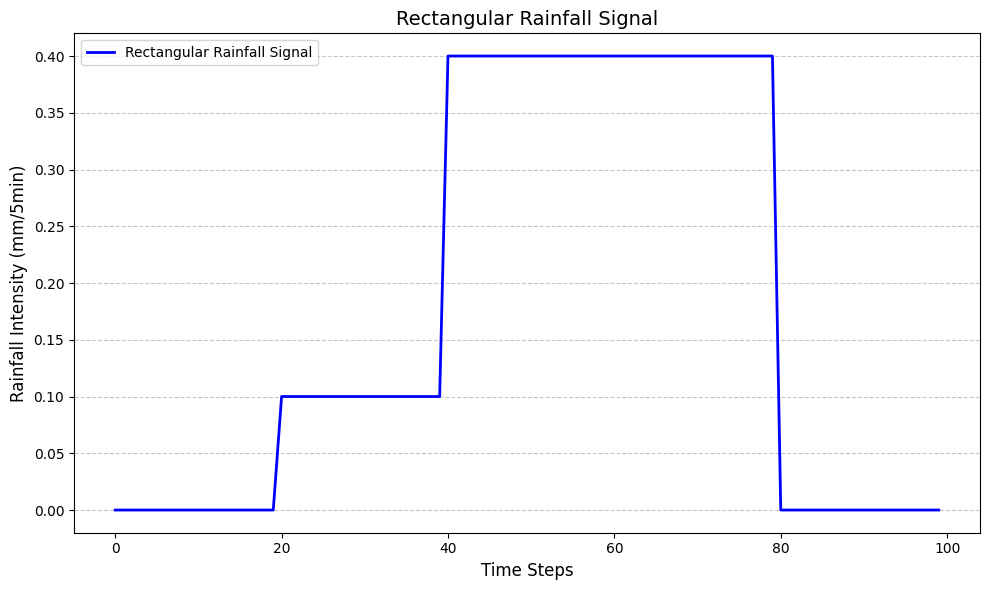

In [12]:

# rectangular signal
def doublerec(duration=100, intensity=5, start=20, end1=40,end2=80):
    """
    Create a rectangular rainfall signal.

    Parameters:
    - duration: number of time step.
    - intensity: Rainfall intensity during the rectangular event (in mm/5min).
    - start: Start time step of the rainfall event.
    - end: End time step of the rainfall event.

    Returns:
    - rainfall: An array containing the rectangular rainfall signal.
    - time: An array containing the time steps.
    """
    time2 = np.arange(duration)
    rainfall2 = np.zeros_like(time2, dtype=float)
    rainfall2[start:end1] = intensity# Create the rectangular rainfall signal
    rainfall2[end1:end2]= intensity*4
    return time2, rainfall2

# Generate a rectangular rainfall signal
time2, rainfall2 = doublerec(duration=100, intensity=0.1, start=20, end1=40,end2=80)

# Plot the rectangular rainfall signal
plt.figure(figsize=(10, 6))
plt.plot(time2, rainfall2, label="Rectangular Rainfall Signal", color="blue", linewidth=2)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Rainfall Intensity (mm/5min)", fontsize=12)
plt.title("Rectangular Rainfall Signal", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


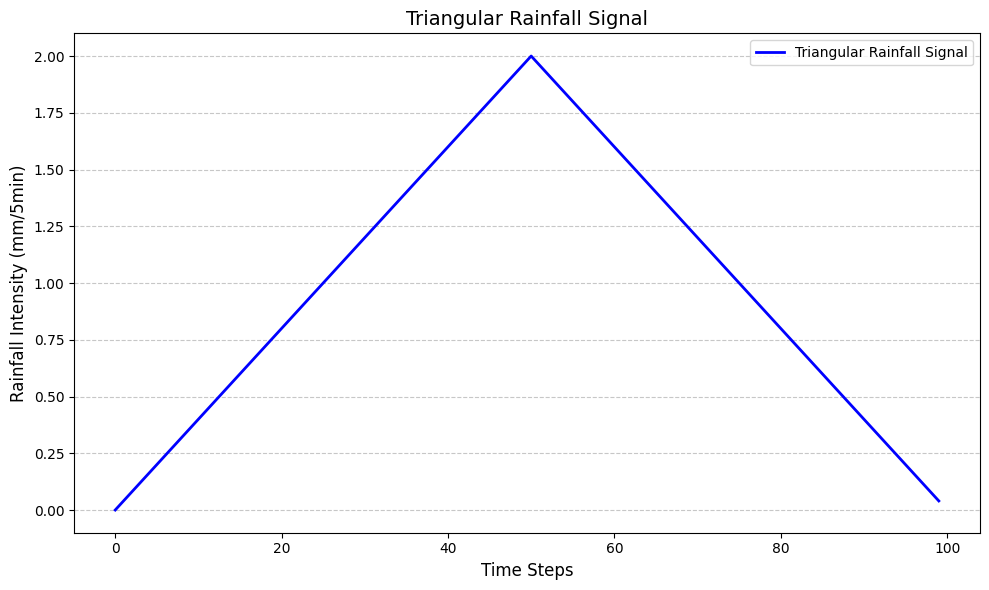

In [13]:
def create_triangular_rainfall_signal(duration=100, peak_intensity=5, peak_time=50):
    """
    Create a triangular rainfall signal.

    Parameters:
    - duration: Total duration of the signal (number of time steps).
    - peak_intensity: Maximum rainfall intensity (at the peak of the triangle, in mm/5min).
    - peak_time: Time step where the peak intensity occurs.

    Returns:
    - rainfall: A NumPy array containing the triangular rainfall signal.
    - time: A NumPy array containing the time steps.
    """
    time3 = np.arange(duration)
    rainfall3 = np.zeros_like(time3, dtype=float)
    
    # Create the rising edge of the triangle
    for t in range(peak_time):
        rainfall3[t] = (peak_intensity / peak_time) * t
    
    # Create the falling edge of the triangle
    for t in range(peak_time, duration):
        rainfall3[t] = peak_intensity - (peak_intensity / (duration - peak_time)) * (t - peak_time)
    
    return time3, rainfall3

# Generate a triangular rainfall signal
time3, rainfall3 = create_triangular_rainfall_signal(duration=100, peak_intensity=2, peak_time=50)

# Plot the triangular rainfall signal
plt.figure(figsize=(10, 6))
plt.plot(time3, rainfall3, label="Triangular Rainfall Signal", color="blue", linewidth=2)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Rainfall Intensity (mm/5min)", fontsize=12)
plt.title("Triangular Rainfall Signal", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [10]:
##THIS ONE IS THE CORRECT

def modified_rainfall_with_memory(original_rainfall, ic=0.2, T=50, resolution=5):
    """
    Modify rainfall intensity using a memory term with heavyside equation

    Parameters:
    - original_rainfall: Array of original rainfall intensities (i(t)).
    - ic: Critical intensity threshold (mm).
    - T: Memory duration (minutes).
    - resolution: Time resolution of the rainfall data (minutes).

    Returns:
    - modified_rainfall: Array of modified rainfall intensities (im(t)).
    """
    dt = resolution  # Time step in minutes
    T_steps = T // resolution  # Memory duration in terms of time steps
    alpha = 0.7
    # Initialize modified rainfall array
    modified_rainfall = np.zeros_like(original_rainfall)

    for t in range(len(original_rainfall)):
        # First term
        if original_rainfall[t] > ic:
            direct_contribution = original_rainfall[t]
        else:
            direct_contribution = 0

        # Second term 
        memory_contribution = 0
        for tau in range(T_steps):
            if t - tau >= 0:  # Ensure valid index
                past_rainfall = original_rainfall[t - tau]
                if past_rainfall <= ic:  # Only consider rainfall below ic
                    memory_contribution += past_rainfall*alpha*(tau/T_steps)*np.exp((tau-T_steps)/T_steps)

        memory_contribution /= T_steps

        # Combine contributions
        modified_rainfall[t] = direct_contribution + memory_contribution

    return modified_rainfall

In [104]:
### 2ND TRY

import numpy as np

import numpy as np

def modified_rainfall_with_memory(original_rainfall, ic=0.2, T=50, resolution=5,
                                                              tail_duration_minutes=100000, dry_lag_minutes=30):
    """
    Modify rainfall intensity:
    - Fast memory (your model).
    - Long tail to preserve integral (for events above and below ic).
    
    Parameters:
    - original_rainfall: Array of rainfall intensities.
    - ic: Critical intensity threshold (mm).
    - T: Memory duration (minutes).
    - resolution: Time resolution (minutes).
    - tail_duration_minutes: Duration of tail in minutes.
    - dry_lag_minutes: Wait time to end an event (minutes).
    
    Returns:
    - modified_rainfall: Rainfall series with preserved integral.
    """
    dt = resolution
    T_steps = T // dt
    tail_steps = tail_duration_minutes // dt
    dry_lag_steps = dry_lag_minutes // dt
    alpha = 0.7

    modified_rainfall = np.zeros_like(original_rainfall, dtype=float)

    # Step 1: Apply the fast memory logic to the entire series (your base model)
    for t in range(len(original_rainfall)):
        if original_rainfall[t] > ic:
            direct_contribution = original_rainfall[t]
        else:
            direct_contribution = 0

        memory_contribution = 0
        for tau in range(T_steps):
            if t - tau >= 0:
                past_rainfall = original_rainfall[t - tau]
                if past_rainfall <= ic:
                    weight = alpha * (tau / T_steps) * np.exp((tau - T_steps) / T_steps)
                    memory_contribution += past_rainfall * weight
        memory_contribution /= T_steps

        modified_rainfall[t] = direct_contribution + memory_contribution

    # Step 2: Detect rain events (continuous rain periods with dry lag)
    rain_active = False
    dry_counter = 0
    event_start = None
    events = []

    for t in range(len(original_rainfall)):
        if original_rainfall[t] > 0:
            if not rain_active:
                event_start = t
                rain_active = True
            dry_counter = 0
        else:
            if rain_active:
                dry_counter += 1
                if dry_counter >= dry_lag_steps:
                    event_end = t - dry_counter
                    events.append((event_start, event_end))
                    rain_active = False

    if rain_active:
        events.append((event_start, len(original_rainfall) - 1))

    print(f"Detected {len(events)} rain events.")

    # Step 3: For each event, compute deficit and apply tail
    for event_start, event_end in events:
        original_event_volume = np.sum(original_rainfall[event_start:event_end + 1]) * dt
        modified_event_volume = np.sum(modified_rainfall[event_start:event_end + 1]) * dt
        volume_deficit = original_event_volume - modified_event_volume

        print(f"Event [{event_start}-{event_end}] Original: {original_event_volume:.4f}, Modified: {modified_event_volume:.4f}, Deficit: {volume_deficit:.4f}")

        if volume_deficit > 0:
            tail_start = event_end + dry_lag_steps + 1

            if tail_start >= len(original_rainfall):
                print(f"No space to add tail after event [{event_start}-{event_end}]")
                continue

            tail_intensity = volume_deficit / (tail_steps * dt)
            print(f"Adding tail after index {tail_start} with intensity {tail_intensity:.6f} mm per step for {tail_steps} steps.")

            for t in range(tail_start, tail_start + tail_steps):
                if t < len(modified_rainfall):
                    modified_rainfall[t] += tail_intensity
                else:
                    break

    # Step 4: Final volume check
    total_original_volume = np.sum(original_rainfall) * dt
    total_modified_volume = np.sum(modified_rainfall) * dt
    print(f"\nFinal Volume Check - Original: {total_original_volume:.4f} mm*min, Modified: {total_modified_volume:.4f} mm*min")

    return modified_rainfall


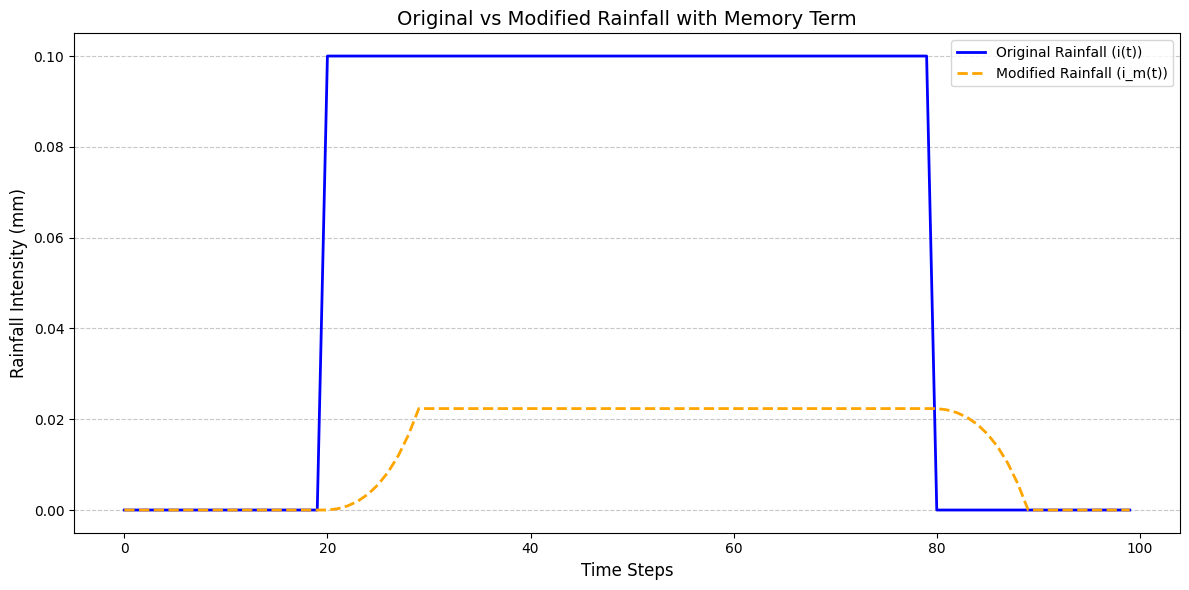

In [14]:

# Parameters
ic = 0.21 # Critical intensity
T = 50  # Memory duration (minutes)
resolution = 5  # Time resolution (minutes)

# Apply the memory modification
modified_rainfall = modified_rainfall_with_memory(rainfall, ic=ic, resolution=resolution)
modif_2 = modified_rainfall_with_memory(rainfall2, ic=ic, resolution=resolution)
modif_3 = modified_rainfall_with_memory(rainfall3, ic=ic,resolution=resolution)


# Plot original and modified rainfall
plt.figure(figsize=(12, 6))
plt.plot(rainfall, label="Original Rainfall (i(t))", color="blue", linewidth=2)
plt.plot(modified_rainfall, label="Modified Rainfall (i_m(t))", color="orange", linestyle="--", linewidth=2)
#plt.axhline(y=ic, color="green", linestyle=":", label=f"Critical Intensity (i_c = {ic})")
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Rainfall Intensity (mm)", fontsize=12)
plt.title("Original vs Modified Rainfall with Memory Term", fontsize=14)
plt.legend(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("example_1.png", dpi=300)
plt.show()

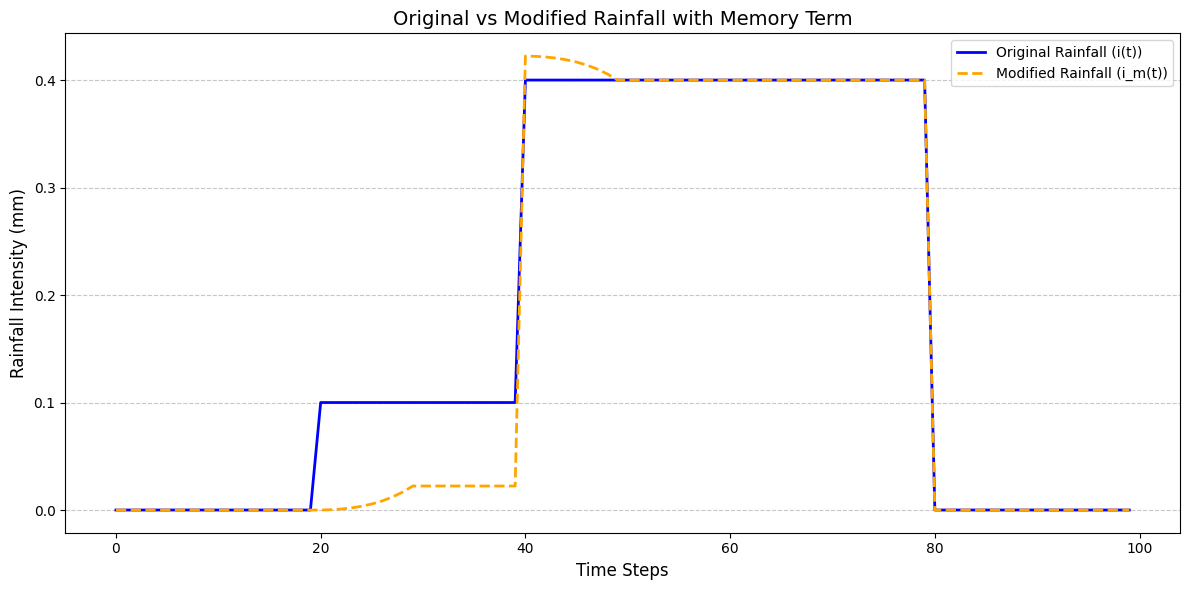

In [15]:
# Plot original and modified rainfall
plt.figure(figsize=(12, 6))
plt.plot(rainfall2, label="Original Rainfall (i(t))", color="blue", linewidth=2)
plt.plot(modif_2, label="Modified Rainfall (i_m(t))", color="orange", linestyle="--", linewidth=2)
#plt.axhline(y=ic, color="green", linestyle=":", label=f"Critical Intensity (i_c = {ic})")
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Rainfall Intensity (mm)", fontsize=12)
plt.title("Original vs Modified Rainfall with Memory Term", fontsize=14)
plt.legend(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("example_2.png", dpi=300)
plt.show()

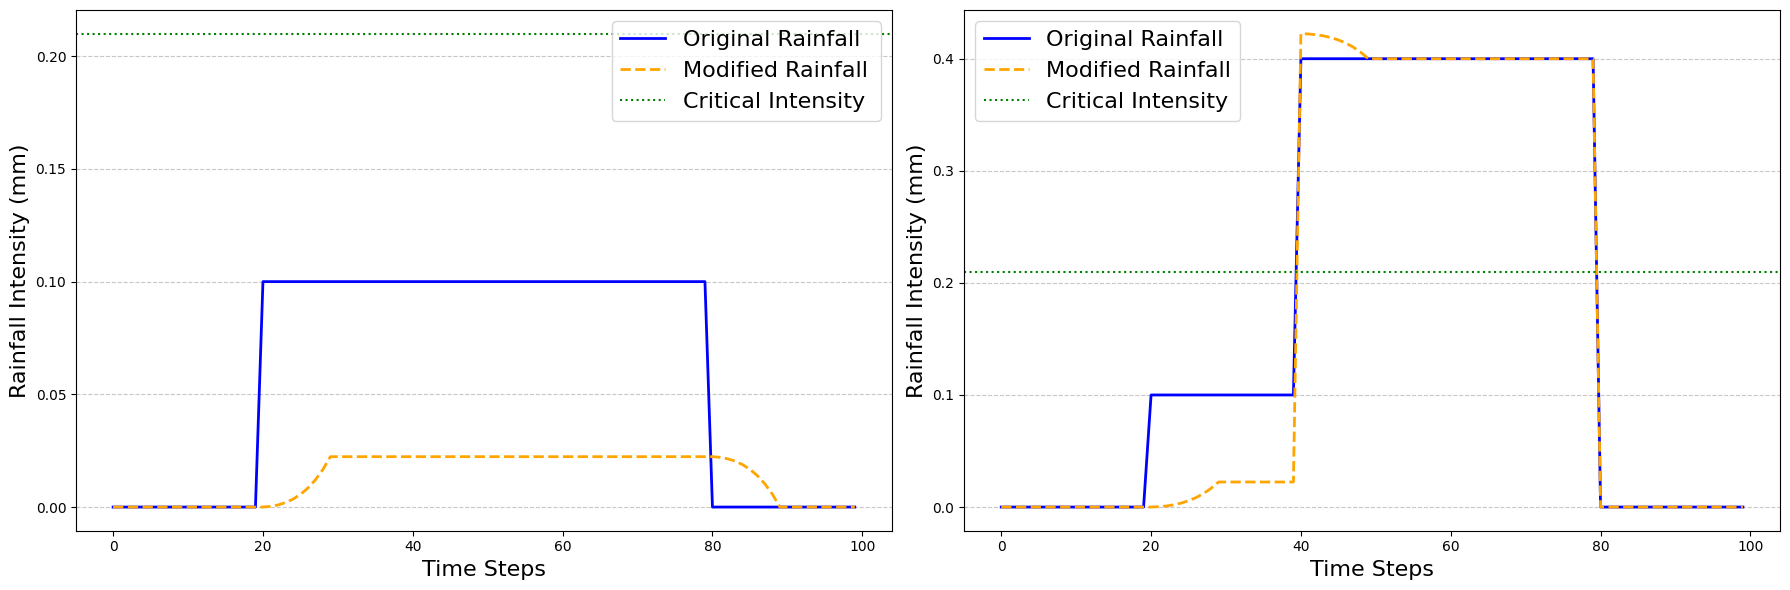

In [17]:
# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# First plot
axes[0].plot(rainfall, label="Original Rainfall", color="blue", linewidth=2)
axes[0].plot(modified_rainfall, label="Modified Rainfall", color="orange", linestyle="--", linewidth=2)
axes[0].axhline(y=ic, color="green", linestyle=":", label=f"Critical Intensity ")
axes[0].set_xlabel("Time Steps", fontsize=16)
axes[0].set_ylabel("Rainfall Intensity (mm)", fontsize=16)
axes[0].legend(fontsize=16)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Second plot
axes[1].plot(rainfall2, label="Original Rainfall", color="blue", linewidth=2)
axes[1].plot(modif_2, label="Modified Rainfall", color="orange", linestyle="--", linewidth=2)
axes[1].axhline(y=ic, color="green", linestyle=":", label=f"Critical Intensity")
axes[1].set_xlabel("Time Steps", fontsize=16)
axes[1].set_ylabel("Rainfall Intensity (mm)", fontsize=16)
axes[1].legend(fontsize=16)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.savefig("combined_plots.png", dpi=300)
plt.show()


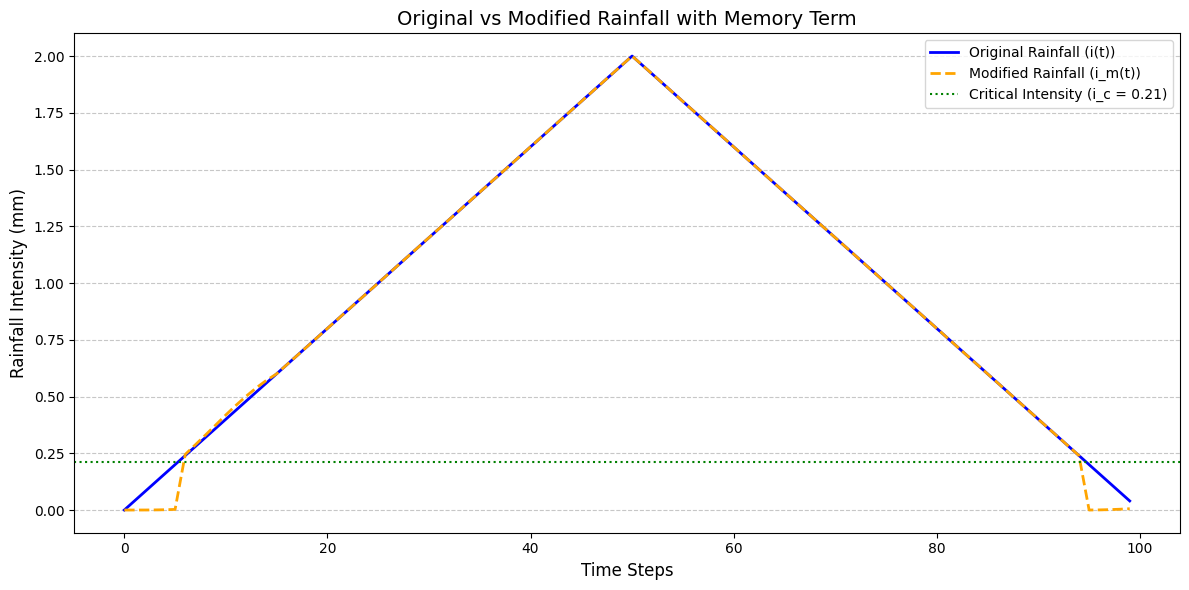

In [42]:
# Plot original and modified rainfall
plt.figure(figsize=(12, 6))
plt.plot(rainfall3, label="Original Rainfall (i(t))", color="blue", linewidth=2)
plt.plot(modif_3, label="Modified Rainfall (i_m(t))", color="orange", linestyle="--", linewidth=2)
plt.axhline(y=ic, color="green", linestyle=":", label=f"Critical Intensity (i_c = {ic})")
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Rainfall Intensity (mm)", fontsize=12)
plt.title("Original vs Modified Rainfall with Memory Term", fontsize=14)
plt.legend(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Modification of our rainfall

In [51]:
### Modification of 10 yr rainfall

with open('df_precp_10yr.pkl','rb') as f:
    df_precp_10 = pd.read_pickle(f)

In [52]:
df_precp_10

,stn,time,precp
0,LSN,2014-01-01 00:00:00,0.0
1,LSN,2014-01-01 00:10:00,0.0
2,LSN,2014-01-01 00:20:00,0.1
3,LSN,2014-01-01 00:30:00,0.1
4,LSN,2014-01-01 00:40:00,0.1
...,...,...,...
525883,LSN,2023-12-31 23:10:00,0.0
525884,LSN,2023-12-31 23:20:00,0.0
525885,LSN,2023-12-31 23:30:00,0.0
525886,LSN,2023-12-31 23:40:00,0.0


In [53]:
# Convert 'precp' to float, coercing invalid entries to NaN
df_precp_10['precp'] = pd.to_numeric(df_precp_10['precp'], errors='coerce')

# Verify the data type
print(df_precp_10['precp'].dtypes)  # Should output: float64

float64


In [54]:
#The resolution is 10 minutes in this case, and we put T at 100 and we double as well the critical intensity

rain_10 = modified_rainfall_with_memory(df_precp_10['precp'], ic=0.42, T=100, resolution=10)

In [55]:
df_precp_10['precp2'] = rain_10

# Save df_pluvio_2 as a pickle file

df_precp_10.to_pickle("df_precp_10yr.pkl")

print("DataFrame saved as df_precp_10yr.pkl")


DataFrame saved as df_precp_10yr.pkl


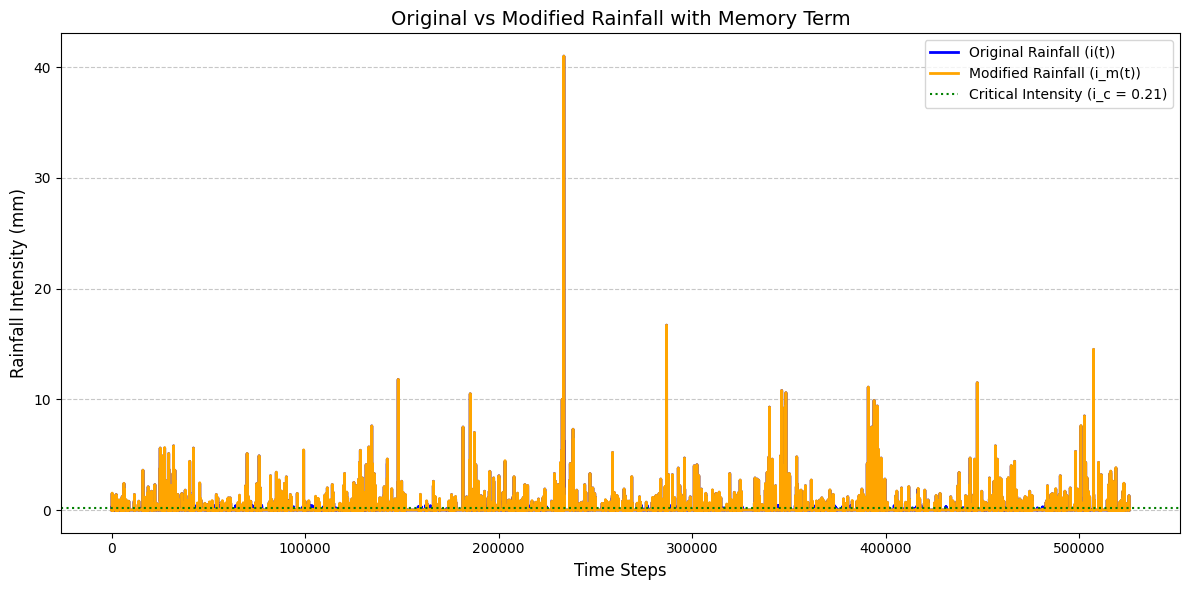

In [48]:
# Plot original and modified rainfall
plt.figure(figsize=(12, 6))
plt.plot(df_precp_10['precp'], label="Original Rainfall (i(t))", color="blue", linewidth=2)
plt.plot(rain_10, label="Modified Rainfall (i_m(t))", color="orange", linewidth=2)
plt.axhline(y=ic, color="green", linestyle=":", label=f"Critical Intensity (i_c = {ic})")
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Rainfall Intensity (mm)", fontsize=12)
plt.title("Original vs Modified Rainfall with Memory Term", fontsize=14)
plt.legend(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [49]:
test_rainfall = modified_rainfall_with_memory(df_pluvio_2['precp'], ic=ic, T=T, resolution=resolution)

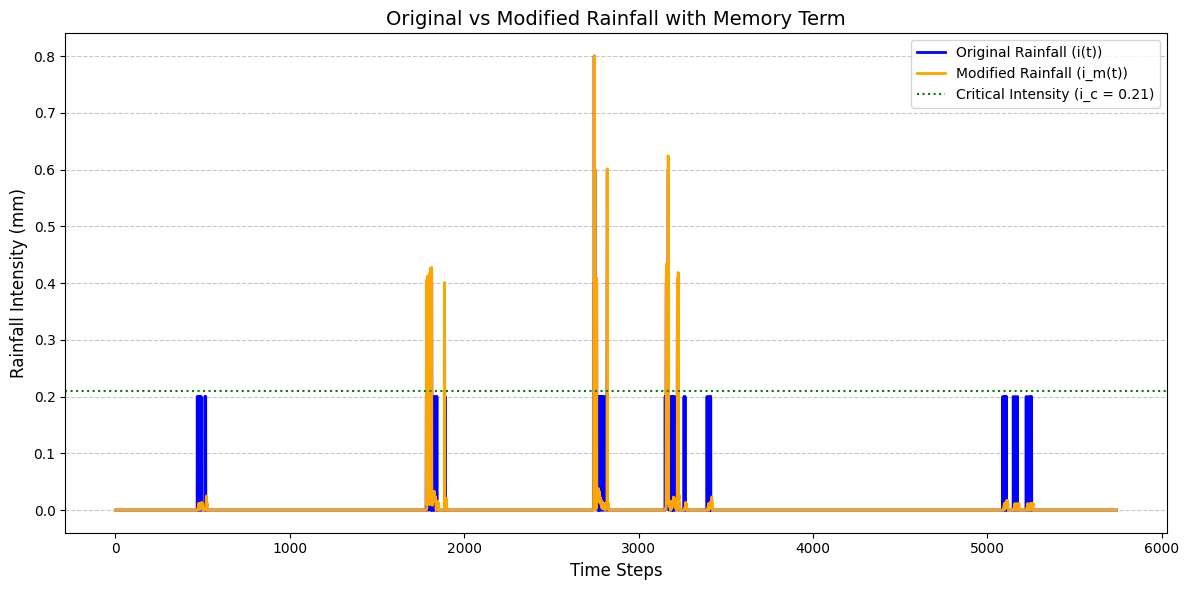

In [93]:
# Plot original and modified rainfall
plt.figure(figsize=(12, 6))
plt.plot(df_pluvio_2['precp'], label="Original Rainfall (i(t))", color="blue", linewidth=2)
plt.plot(test_rainfall, label="Modified Rainfall (i_m(t))", color="orange", linewidth=2)
plt.axhline(y=ic, color="green", linestyle=":", label=f"Critical Intensity (i_c = {ic})")
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Rainfall Intensity (mm)", fontsize=12)
plt.title("Original vs Modified Rainfall with Memory Term", fontsize=14)
plt.legend(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [50]:
df_pluvio_2['precp2'] = test_rainfall

# Save df_pluvio_2 as a pickle file

df_pluvio_2.to_pickle("pluvio_2.pkl")

print("DataFrame saved as pluvio_2.pkl")


DataFrame saved as pluvio_2.pkl


#### Event 1

In [ ]:
# Plot original and modified rainfall
plt.figure(figsize=(12, 6))
plt.plot(df_pluvio_2['precp'][400:600], label="Original Rainfall (i(t))", color="blue", linewidth=2)
plt.plot(df_pluvio_2['precp2'][400:600], label="Modified Rainfall (i_m(t))", color="orange", linestyle="--", linewidth=2)
plt.axhline(y=ic, color="green", linestyle=":", label=f"Critical Intensity (i_c = {ic})")
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Rainfall Intensity (mm)", fontsize=12)
plt.title("Original vs Modified Rainfall with Memory Term", fontsize=14)
plt.legend(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Event 2

In [ ]:
# Plot original and modified rainfall
plt.figure(figsize=(12, 6))
plt.plot(df_pluvio_2['precp'][1750:1950], label="Original Rainfall (i(t))", color="blue", linewidth=2)
plt.plot(df_pluvio_2['precp2'][1750:1950], label="Modified Rainfall (i_m(t))", color="orange", linestyle="--", linewidth=2)
plt.axhline(y=ic, color="green", linestyle=":", label=f"Critical Intensity (i_c = {ic})")
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Rainfall Intensity (mm)", fontsize=12)
plt.title("Original vs Modified Rainfall with Memory Term", fontsize=14)
plt.legend(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Event 3

In [ ]:
# Plot original and modified rainfall
plt.figure(figsize=(12, 6))
plt.plot(df_pluvio_2['precp'][2720:2850], label="Original Rainfall (i(t))", color="blue", linewidth=2)
plt.plot(df_pluvio_2['precp2'][2720:2850], label="Modified Rainfall (i_m(t))", color="orange", linestyle="--", linewidth=2)
plt.axhline(y=ic, color="green", linestyle=":", label=f"Critical Intensity (i_c = {ic})")
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Rainfall Intensity (mm)", fontsize=12)
plt.title("Original vs Modified Rainfall with Memory Term", fontsize=14)
plt.legend(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Event 4

In [ ]:
# Plot original and modified rainfall
plt.figure(figsize=(12, 6))
plt.plot(df_pluvio_2['precp'][3120:3300], label="Original Rainfall (i(t))", color="blue", linewidth=2)
plt.plot(df_pluvio_2['precp2'][3120:3300], label="Modified Rainfall (i_m(t))", color="orange", linestyle="--", linewidth=2)
plt.axhline(y=ic, color="green", linestyle=":", label=f"Critical Intensity (i_c = {ic})")
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Rainfall Intensity (mm)", fontsize=12)
plt.title("Original vs Modified Rainfall with Memory Term", fontsize=14)
plt.legend(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Event 5

In [ ]:
# Plot original and modified rainfall
plt.figure(figsize=(12, 6))
plt.plot(df_pluvio_2['precp'][5050:5300], label="Original Rainfall (i(t))", color="blue", linewidth=2)
plt.plot(df_pluvio_2['precp2'][5050:5300], label="Modified Rainfall (i_m(t))", color="orange", linestyle="--", linewidth=2)
plt.axhline(y=ic, color="green", linestyle=":", label=f"Critical Intensity (i_c = {ic})")
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Rainfall Intensity (mm)", fontsize=12)
plt.title("Original vs Modified Rainfall with Memory Term", fontsize=14)
plt.legend(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### Now we have applied the model on the new rain

In [ ]:
with open('df_model_test.pkl','rb') as f:
    df_model_test = pd.read_pickle(f)

In [ ]:
df_model_test
df_model_test['Qout']=df_model_test['Qout']

In [ ]:
df_triades2

In [ ]:
# Ensure both datasets have numeric indices
df_model_test.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_test.index, df_model_test['Qout'], label="Qout (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
#plt.plot(df_triades2.index, df_triades2['Flow Rate (Qp)'], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Extract Flow Rate values
flow_rate = df_triades2['Flow Rate Copy'].values

# Time intervals in seconds (5 minutes = 300 seconds)
dx = 300  # seconds

# Calculate the area under the curve using the trapezoidal rule
total_volume = np.trapz(flow_rate, dx=dx)

# Print the result
print(f"Total Volume of Water: {total_volume:.6f} m³")

In [ ]:
# Extract Flow Rate values
flow_rate = df_model_test['Qout'].values

# Time intervals in seconds (5 minutes = 300 seconds)
dx = 300  # seconds

# Calculate the area under the curve using the trapezoidal rule
total_volume = np.trapz(flow_rate, dx=dx)

# Print the result
print(f"Total Volume of Water: {total_volume:.6f} m³")

#### For each event 

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_test.index[400:600], df_model_test['Qout'][400:600], label="Qout (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index[400:600], df_triades2['Flow Rate Copy'][400:600]-0.0006, label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_test.index[1750:1950], df_model_test['Qout'][1750:1950], label="Qout (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index[1750:1950], df_triades2['Flow Rate Copy'][1750:1950]-0.0005, label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
start = 2720
end = 2850

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_test.index[start:end], df_model_test['Qout'][start:end], label="Qout (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index[start:end], df_triades2['Flow Rate Copy'][start:end]-0.0005, label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
start = 3120
end = 3300

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_test.index[start:end], df_model_test['Qout'][start:end], label="Qout (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index[start:end], df_triades2['Flow Rate Copy'][start:end]-0.0005, label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
start = 5050
end = 5300

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_test.index[start:end], df_model_test['Qout'][start:end], label="Qout (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index[start:end], df_triades2['Flow Rate Copy'][start:end]-0.0005, label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
start = 400
end = 600

# Ensure both datasets have numeric indices
df_model_test.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_test.index[start:end], df_model_test['Qout'][start:end], label="Qout memory (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index[start:end], df_triades2['Flow Rate Copy'][start:end]-0.0005, label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)


# Plot Qout using its index
plt.plot(df_model_2.index[start:end], df_model_2['Qout'][start:end], label="Qout original (Modeled Runoff)", color="green", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Ensure both datasets have numeric indices
df_model_test.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_test.index, df_model_test['Qout'], label="Qout memory (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index, df_triades2['Flow Rate Copy'], label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)


# Plot Qout using its index
plt.plot(df_model_2.index, df_model_2['Qout'], label="Qout original (Modeled Runoff)", color="green", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
start = 1750
end = 1950

# Ensure both datasets have numeric indices
df_model_test.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_test.index[start:end], df_model_test['Qout'][start:end], label="Qout memory (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index[start:end], df_triades2['Flow Rate Copy'][start:end]-0.0004, label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)


# Plot Qout using its index
plt.plot(df_model_2.index[start:end], df_model_2['Qout'][start:end], label="Qout original (Modeled Runoff)", color="green", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
start = 2720
end = 2840

# Ensure both datasets have numeric indices
df_model_test.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_test.index[start:end], df_model_test['Qout'][start:end], label="Qout memory (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index[start:end], df_triades2['Flow Rate Copy'][start:end]-0.0004, label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)


# Plot Qout using its index
plt.plot(df_model_2.index[start:end], df_model_2['Qout'][start:end], label="Qout original (Modeled Runoff)", color="green", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
start = 3120
end = 3300

# Ensure both datasets have numeric indices
df_model_test.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_test.index[start:end], df_model_test['Qout'][start:end], label="Qout memory (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index[start:end], df_triades2['Flow Rate Copy'][start:end]-0.0004, label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)


# Plot Qout using its index
plt.plot(df_model_2.index[start:end], df_model_2['Qout'][start:end], label="Qout original (Modeled Runoff)", color="green", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
start = 5000
end = 5300

# Ensure both datasets have numeric indices
df_model_test.reset_index(drop=True, inplace=True)
df_triades2.reset_index(drop=True, inplace=True)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot Qout using its index
plt.plot(df_model_test.index[start:end], df_model_test['Qout'][start:end], label="Qout memory (Modeled Runoff)", color="blue", linewidth=2)

# Plot Flow Rate (Qp) using its index
plt.plot(df_triades2.index[start:end], df_triades2['Flow Rate Copy'][start:end]-0.0004, label="Flow Rate (Qp) (Observed)", color="red", linewidth=2)


# Plot Qout using its index
plt.plot(df_model_2.index[start:end], df_model_2['Qout'][start:end], label="Qout original (Modeled Runoff)", color="green", linewidth=2)

# Add labels, title, and legend
plt.xlabel("Index (Time Steps)", fontsize=14)
plt.ylabel("Flow Rate (m³/s)", fontsize=14)
plt.title("Comparison of Modeled Runoff (Qout) and Observed modified Flow Rate (Qp) ", fontsize=16)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Extract Flow Rate values
flow_rate = df_model_test['Qout'].values

# Time intervals in seconds (5 minutes = 300 seconds)
dx = 300  # seconds

# Calculate the area under the curve using the trapezoidal rule
total_volume = np.trapz(flow_rate, dx=dx)

# Print the result
print(f"Total Volume of Water: {total_volume:.6f} m³")

In [ ]:
# Extract Flow Rate values
flow_rate = df_triades2['Flow Rate (Qp)'].values
flow_rate = flow_rate - 0.00047

# Time intervals in seconds (5 minutes = 300 seconds)
dx = 300  # seconds

# Calculate the area under the curve using the trapezoidal rule
total_volume = np.trapz(flow_rate, dx=dx)

# Print the result
print(f"Total Volume of Water: {total_volume:.6f} m³")

In [ ]:
np.sum(df_pluvio_2['precp'])*24365.7/1000